# Communication-Aware Clustered Federated Learning: How to Leverage Data Heterogeneity

- Import modules contains imported modules, seeds for random computations and TPU configuration
- Methods, objects and models contains all the methods to manage the datasets, create the users-clusters setup, initialize CNNs and NICEs and plot the results
- System and data initialization initialize users, clusters, data for each of them...
ALL of the previous sections must be executed!
- CNN Training contains CNN training method and computation of local accuracy
- NICE Training contains NICE training method
- Test section contains a method to evaluate global performances of the model that average the predictions (without estimated marginals), the model with the marginals, and other ideas...
(to update)

# Import modules

In [ ]:
from matplotlib import pyplot as plt
import random as rnd
import numpy as np
import collections
import os
import math

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from scipy.special import softmax
from skimage import io
!git clone git://github.com/nicolagulmini/federated_learning

tf.random.set_seed(42)
np.random.seed(42)
rnd.seed(42)

# for tensorflow warnings.
import logging
tf.get_logger().setLevel(logging.ERROR)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Methods, objects and models

In [ ]:
class cluster:
    def __init__(self, number):
        self.users = []
        self.number = number
    def number_of_users(self):
        return len(self.users)
    def add_user(self, user):
        self.users.append(user)
    def set_train_data(self, train_data):
        self.train_data = train_data
    def set_test_data(self, test_data):
        self.test_data = test_data
    def set_model(self, model):
        self.model = model
    def set_estimation(self, estimation):
        self.estimation = estimation
        
class user_information:
    def __init__(self, name, cluster):
        self.name = name
        self.cluster = cluster
    def set_data(self, data):
        self.data = data
    def set_accuracy(self, accuracy):
        self.accuracy = accuracy
    def get_accuracy(self):
        return self.accuracy
    def set_model(self, model):
        self.model = model
    def get_model(self):
        return self.model
    def set_estimation(self, estimation):
        self.estimation = estimation
    def get_estimation(self):
        return self.estimation
    def model_size(self):
        return number_of_parameters(self.get_model().get_weights())
    def buffer_size(self):
        return self.model_size()+self.estimation_size()

In [ ]:
img = io.imread('federated_learning/federated_mnist/0/training_images/0.png', as_gray=True)
print(img)

In [ ]:
cifar_classes = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}

classes = {
    0 : "zero",
    1 : "one",
    2 : "two",
    3 : "three",
    4 : "four",
    5 : "five",
    6 : "six",
    7 : "seven",
    8 : "eight",
    9 : "nine",
}

In [ ]:
def load_preprocessed_cifar10_ds():
    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
    num_classes = len(classes)
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    Y_train = to_categorical(Y_train, num_classes)
    Y_test = to_categorical(Y_test, num_classes)
    return X_train, Y_train, X_test, Y_test

def load_preprocessed_mnist():
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    num_classes = len(classes)
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    Y_train = to_categorical(Y_train, num_classes)
    Y_test = to_categorical(Y_test, num_classes)
    return X_train, Y_train, X_test, Y_test

In [ ]:
def create_dictionary_from_dataset(dataset):
    division = collections.defaultdict(list)
    for v, k in dataset:
        label = int(np.argmax(k))
        division[label].append(v)
    return division

def assign_users_to_clusters_randomly(users_ids, number_of_clusters):
    tmp_ids = users_ids
    number_of_users = len(tmp_ids)
    users_per_cluster = int(number_of_users/number_of_clusters)
    clusters = []
    for i in range(number_of_clusters):
        tmp_cluster = cluster(number=i)
        for _ in range(users_per_cluster):
            user = rnd.choices(tmp_ids)[0]
            tmp_ids.remove(user)
            tmp_user = user_information(user, i)
            tmp_cluster.add_user(tmp_user)
        clusters.append(tmp_cluster)
        print('Users in cluster', tmp_cluster.number, 'are:', [u.name for u in tmp_cluster.users])
        del tmp_cluster
    return clusters

def ds_division(X, division, heterogeneity_factor, number_of_clusters, fav_classes):
    remaining_weights = (1-heterogeneity_factor)/9
    cluster_img = int(len(X)/number_of_clusters)
    cluster_ds = collections.OrderedDict()
    for i in range(number_of_clusters):
        fav_class = fav_classes[i]
        classes_weights = [remaining_weights for _ in classes]
        classes_weights[fav_class] = heterogeneity_factor
        cluster_X = np.zeros((cluster_img, 28, 28))
        cluster_Y = np.zeros((cluster_img, 10))
        for j in range(cluster_img):
            chosen_class = rnd.choices(list(range(10)), classes_weights)[0] # because it is a 1-dimensional vector
            images_from_class = division[chosen_class]
            chosen_image = images_from_class[np.random.randint(0, len(images_from_class))]
            cluster_X[j] = chosen_image
            cluster_Y[j] = to_categorical(chosen_class, len(classes))
        cluster_ds[i] = collections.OrderedDict((('labels', cluster_Y), ('images', cluster_X)))
    return cluster_ds

In [ ]:
def train_validation_split(X_train, Y_train):
    train_length = len(X_train)
    validation_length = int(train_length / 4)
    X_validation = X_train[:validation_length]
    X_train = X_train[validation_length:]
    Y_validation = Y_train[:validation_length]
    Y_train = Y_train[validation_length:]
    return X_train, Y_train, X_validation, Y_validation

In [ ]:
class define_model_cifar():
    def __init__(self):
        self.model = Sequential()
        self.model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.2)) 
        self.model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.3))
        self.model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.4))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        self.model.add(Dense(10, activation='softmax'))
        opt = Adam(lr=0.001)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class define_model_mnist():
    def __init__(self):
        self.model = Sequential()
        self.model.add(Flatten(input_shape=(28, 28)))
        self.model.add(Dense(10, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

class define_autoencoder_mnist():
    def __init__(self):
        self.model = Sequential()
        self.model.add(Flatten(input_shape=(28, 28)))
        self.model.add(Dense(10, activation='relu'))
        self.model.add(Dense(784, activation='sigmoid'))
        self.model.add(Reshape((28, 28)))
        self.model.compile(optimizer='adam', loss='binary_crossentropy')

Model: "sequential_374"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_374 (Flatten)        (None, 784)               0         
_________________________________________________________________
dense_748 (Dense)            (None, 10)                7850      
_________________________________________________________________
dense_749 (Dense)            (None, 784)               8624      
_________________________________________________________________
reshape_32 (Reshape)         (None, 28, 28)            0         
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________
63/63 [==============================] - 0s 6ms/step - loss: 0.2281 - binary_crossentropy: 0.2281
local: 0.6985999941825867
313/313 [==============================] - 2s 6ms/step - loss: 0.2451 - binary_crossentropy: 0.2451
global 0.6985999941825

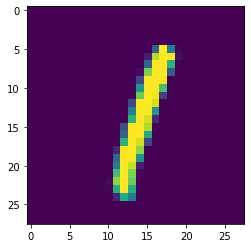

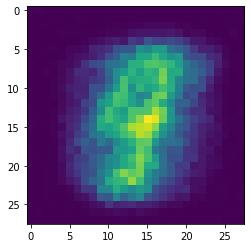

In [ ]:
## piccola prova

template_model = define_autoencoder_mnist().model 
template_model.summary()
X_test = clusters[0].test_data['images']
X_train_u, Y_train_u, X_validation_u, Y_validation_u = train_validation_split(clusters[0].users[0].data['images'], clusters[0].users[0].data['labels'])
history = template_model.fit(X_train_u, X_train_u, epochs=5, batch_size=32, verbose=0, validation_data=(X_validation_u, X_validation_u))
loss = template_model.evaluate(X_test, X_test)
print('local:', accuracy)
X_train, Y_train, X_test, Y_test = load_preprocessed_mnist()
loss = template_model.evaluate(X_test, X_test)
print('global', accuracy)

index = 5
img = X_test[index]
plt.figure()
plt.imshow(img)
loss = template_model.evaluate(img.reshape((1, 28, 28)), img.reshape((1, 28, 28)))  
reconst = template_model.predict(img.reshape((1, 28, 28)))
print(loss)
plt.figure()
plt.imshow(reconst.reshape((28, 28)))

In [ ]:
ret = template_model.evaluate(X_test, X_test)
print(ret)

NameError: ignored

In [ ]:
def initialize_models(clusters, server):
    # no sparsification at the first stage
    w = server.model.get_weights()

    for cluster in clusters:

        # classification model cluster initialization
        tmp_cluster_model = define_model_mnist() # these steps are in order to create one model for each cluster and user, instead of the same model shared among all
        tmp_cluster_model.model.set_weights(w)
        cluster.set_model(tmp_cluster_model.model)
        del tmp_cluster_model

        # "estimation" cluster initialization
        tmp_cluster_estimation_model = define_autoencoder_mnist() # these steps are in order to create one model for each cluster and user, instead of the same model shared among all
        cluster.set_estimation(tmp_cluster_estimation_model.model)
        del tmp_cluster_estimation_model

        for user in cluster.users:

            # initialize user classification model from cluster
            tmp_user_model = define_model_mnist()
            tmp_user_model.model.set_weights(cluster.model.get_weights())
            user.set_model(tmp_user_model.model)
            del tmp_user_model

            # initialize user estimation from cluster
            tmp_user_estimation_model = define_autoencoder_mnist()
            tmp_user_estimation_model.model.set_weights(cluster.estimation.get_weights())
            user.set_estimation(tmp_user_estimation_model.model)
            del tmp_user_estimation_model

def top_k_sparsificate_model_weights_tf(weights, fraction, number_of_total_parameters):
    tmp_list = []
    for el in weights:
        lay_list = el.reshape((-1)).tolist()
        tmp_list = tmp_list + [abs(el) for el in lay_list]
    tmp_list.sort(reverse=True)
    k_th_element = tmp_list[int(fraction*number_of_total_parameters)-1] # 552874 is the number of parameters of the CNNs! for cifar10
    new_weights = []
    for el in weights:
        original_shape = el.shape
        reshaped_el = el.reshape((-1))
        for i in range(len(reshaped_el)):
            if abs(reshaped_el[i]) < k_th_element:
                reshaped_el[i] = 0.0
        new_weights.append(reshaped_el.reshape(original_shape))
    return new_weights

def transfer_cluster_model_to_users(cluster):
    for user in cluster.users:
        user.model.set_weights(cluster.model.get_weights())
        
def transfer_cluster_estimation_to_users(cluster):
    for user in cluster.users:
        user.estimation.set_weights(cluster.estimation.get_weights())

In [ ]:
def missing_class_dataset_division(X, division, heterogeneity_factor, number_of_clusters, fav_classes, not_wanted_classes):
    remaining_weights = (1-heterogeneity_factor)/8
    cluster_img = int(len(X)/number_of_clusters)
    cluster_ds = collections.OrderedDict()
    for i in range(number_of_clusters):
        not_wanted_class = not_wanted_classes[i]
        fav_class = fav_classes[i]
        classes_weights = [remaining_weights for _ in classes]
        classes_weights[fav_class] = heterogeneity_factor
        classes_weights[not_wanted_class] = 0
        cluster_X = np.zeros((cluster_img, 32, 32, 3))
        cluster_Y = np.zeros((cluster_img, 10))
        for j in range(cluster_img):
            chosen_class = rnd.choices(list(range(10)), classes_weights)[0] # because it is a 1-dimensional vector
            images_from_class = division[chosen_class]
            chosen_image = images_from_class[np.random.randint(0, len(images_from_class))]
            cluster_X[j] = chosen_image
            cluster_Y[j] = to_categorical(chosen_class, len(classes))
        cluster_ds[i] = collections.OrderedDict((('labels', cluster_Y), ('images', cluster_X)))
    return cluster_ds

# System and data initialization

In [ ]:
number_of_users = 20
number_of_clusters = 5
bias_factor = 0.5

epochs = 6
estimation_epochs = 10
batch = 16
estimation_batch = 32
iterations = 7

In [ ]:
classification_percentage = 30
estimation_percentage = 90

In [ ]:
users_ids = list(range(number_of_users))
print('Users ids list:', users_ids)
X_train, Y_train, X_test, Y_test = load_preprocessed_mnist()

division_train = create_dictionary_from_dataset(tf.data.Dataset.from_tensor_slices((X_train, Y_train)))
division_test = create_dictionary_from_dataset(tf.data.Dataset.from_tensor_slices((X_test, Y_test)))

Users ids list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
clusters = assign_users_to_clusters_randomly(list(range(number_of_users)), number_of_clusters)
fav_classes = [np.random.randint(0, 10) for _ in range(number_of_clusters)] # to obtain the same heterogeneity for train and test datasets

print('')
for c in range(len(fav_classes)):
    print("Bias label of the cluster " + str(c) + " is " + str(fav_classes[c]) + ": " + str(classes[fav_classes[c]]))

"""
MNIST:

Users in cluster 0 are: [12, 0, 5, 4]
Users in cluster 1 are: [15, 14, 18, 2]
Users in cluster 2 are: [9, 1, 7, 11]
Users in cluster 3 are: [3, 8, 16, 13]
Users in cluster 4 are: [6, 17, 19, 10]

Bias label of the cluster 0 is 6: six
Bias label of the cluster 1 is 3: three
Bias label of the cluster 2 is 7: seven
Bias label of the cluster 3 is 4: four
Bias label of the cluster 4 is 6: six
"""

Users in cluster 0 are: [12, 0, 5, 4]
Users in cluster 1 are: [15, 14, 18, 2]
Users in cluster 2 are: [9, 1, 7, 11]
Users in cluster 3 are: [3, 8, 16, 13]
Users in cluster 4 are: [6, 17, 19, 10]

Bias label of the cluster 0 is 6: six
Bias label of the cluster 1 is 3: three
Bias label of the cluster 2 is 7: seven
Bias label of the cluster 3 is 4: four
Bias label of the cluster 4 is 6: six


'\nMNIST:\n\nUsers in cluster 0 are: [12, 0, 5, 4]\nUsers in cluster 1 are: [15, 14, 18, 2]\nUsers in cluster 2 are: [9, 1, 7, 11]\nUsers in cluster 3 are: [3, 8, 16, 13]\nUsers in cluster 4 are: [6, 17, 19, 10]\n\nBias label of the cluster 0 is 6: six\nBias label of the cluster 1 is 3: three\nBias label of the cluster 2 is 7: seven\nBias label of the cluster 3 is 4: four\nBias label of the cluster 4 is 6: six\n'

In [ ]:
clusters_train_datasets = ds_division(X_train, division_train, bias_factor, number_of_clusters, fav_classes)
clusters_test_datasets = ds_division(X_test, division_test, bias_factor, number_of_clusters, fav_classes)

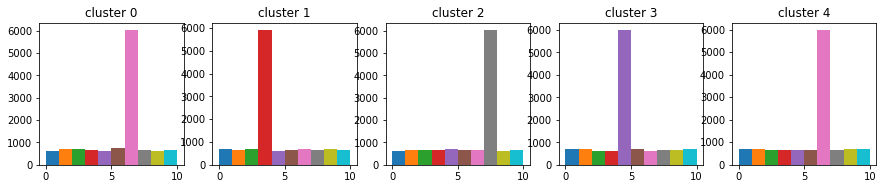

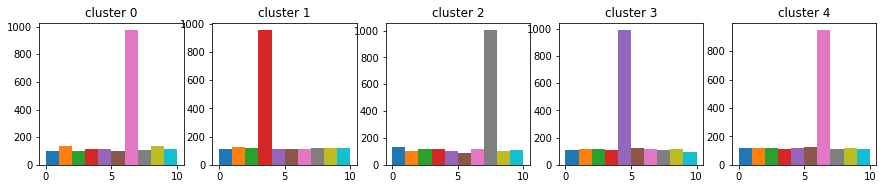

In [ ]:
f = plt.figure(figsize=(15, 12))
i = 0 # to plot
for cluster in range(number_of_clusters):
    cluster_ds = clusters_train_datasets[cluster]
    plot_data = collections.defaultdict(list)
    for el in cluster_ds['labels']:
        label = int(np.argmax(el))
        plot_data[label].append(label)
    plt.subplot(4, 5, i+1)
    i += 1
    plt.title('cluster ' + str(cluster))
    for j in range(10):
        plt.hist(plot_data[j], bins=range(11))

# plot test dataset histograms for clusters
f = plt.figure(figsize=(15, 12))
i = 0 # to plot
for cluster in range(number_of_clusters):
    cluster_ds = clusters_test_datasets[cluster]
    plot_data = collections.defaultdict(list)
    for el in cluster_ds['labels']:
        label = int(np.argmax(el))
        plot_data[label].append(label)
    plt.subplot(4, 5, i+1)
    i += 1
    plt.title('cluster ' + str(cluster))
    for j in range(10):
        plt.hist(plot_data[j], bins=range(11))

In [ ]:
# distribute the data among clusters
for i in range(len(clusters_train_datasets)):
    clusters[i].set_train_data(clusters_train_datasets[i])
    clusters[i].set_test_data(clusters_test_datasets[i])

# divide the cluster dataset amoung users of the cluster, in a naive way...
for cluster in clusters:
    cluster_ds = cluster.train_data
    cluster_X = cluster_ds['images']
    cluster_Y = cluster_ds['labels']
    shuffler = np.random.permutation(len(cluster_X))
    cluster_X = cluster_X[shuffler]
    cluster_Y = cluster_Y[shuffler]
    size_of_user_ds = int(len(cluster_X) / cluster.number_of_users())
    for i in range(cluster.number_of_users()):
        X_user = cluster_X[size_of_user_ds*i:size_of_user_ds*i+size_of_user_ds]
        Y_user = cluster_Y[size_of_user_ds*i:size_of_user_ds*i+size_of_user_ds]
        user = cluster.users[i]
        user_data = collections.OrderedDict((('labels', Y_user), ('images', X_user)))
        user.set_data(user_data)

In [ ]:
# the server has got a model, randomly initalized, of the same 'shape' of the users single models
server_model = define_model_mnist()
initialize_models(clusters, server_model) #, classification_percentage/100) 

# CNN Training

## ONLY FOR INTERRUPTED TRAINING

In [ ]:
last_iteration_completed = 2
for cluster in clusters:
    name = "/content/drive/MyDrive/Colab Notebooks/cluster"+str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+str(last_iteration_completed)+".h5"
    tmp_model = tf.keras.models.load_model(name)
    cluster.model.set_weights(tmp_model.get_weights())
# modify!

## Training

In [ ]:
def train_user_model(user, cluster, epochs, batch):
    print('Training for user', user.name)
    user_model = user.get_model()
    X_test = cluster.test_data['images']
    Y_test = cluster.test_data['labels']
    _, accuracy = user_model.evaluate(X_test, Y_test)
    print('Test accuracy BEFORE training for user', user.name, 'of cluster', user.cluster, 'is', accuracy)
    user_data = user.data
    X_train_u = user_data['images'][:int(0.05*len(user_data['images']))] # * look at the 22-nd july section
    Y_train_u = user_data['labels'][:int(0.05*len(user_data['labels']))]
    shuffler = np.random.permutation(len(X_train_u))
    X_train_u = X_train_u[shuffler]
    Y_train_u = Y_train_u[shuffler]     
    X_train_u, Y_train_u, X_validation_u, Y_validation_u = train_validation_split(X_train_u, Y_train_u)
    history = user_model.fit(X_train_u, Y_train_u, epochs=epochs, batch_size=batch, verbose=0, validation_data=(X_validation_u, Y_validation_u))
    _, accuracy = user_model.evaluate(X_test, Y_test)
    #summarize_diagnostics(history)
    user.set_model(user_model)
    user.set_accuracy(accuracy) # maybe useless
    print('Test accuracy AFTER training for user', user.name, 'of cluster', user.cluster, 'is', user.get_accuracy())

In [ ]:
# here there is NO parallelization, I train one CNN at a time (and one cluster at a time), in an iterative way

for _ in range(iterations):
    if _ == iterations-1:
        break

    print("\n************ Iteration " + str(_) + " ************")
    print("Sparsification = " + str(classification_percentage) + "%\n")

    for cluster in clusters:
        cluster.model.save("/content/drive/MyDrive/Colab Notebooks/classification_models_mnist/het" + str(int(bias_factor*100)) + "_class_perc" + str(classification_percentage) + "/cluster" + str(cluster.number) + "_iter" + str(_) + ".h5")

    for cluster in clusters:
        transfer_cluster_model_to_users(cluster) 
        # useless at first iteration but fundamental then 
        # not sparsified! Only in the uplink

        for user in cluster.users:
            train_user_model(user, cluster, epochs, batch)
            user.get_model().save("user"+str(user.name)+"_"+str(classification_percentage)+"sparse_iter"+str(_)+".h5")
            # so it saves the users in the volatile space of the colab, and the clusters (the most important model files) in the drive folder!

        print('Start aggregating cluster', cluster.number, 'parameters...')
        # aggregate
        cluster_trainset_size = len(cluster.train_data['images'])
        wc = cluster.model.get_weights()
        sum_terms = []
        for user in cluster.users:
            wu = user.get_model().get_weights()
            nu = len(user.data['labels'])
            frac = nu/cluster_trainset_size
            sum_terms.append([frac*np.subtract(wu[i], wc[i]) for i in range(len(wu))])
        update = sum_terms[0]
        for i in range(1, len(sum_terms)): # can be modified
            tmp = sum_terms[i]
            update = [np.add(tmp[j], update[j]) for j in range(len(update))]
        new_cluster_weights = [np.add(wc[i], update[i]) for i in range(len(wc))]
        sparse_weights = top_k_sparsificate_model_weights_tf(new_cluster_weights, classification_percentage/100, 7850) # 7960 for the other case with the hidden layer
        cluster.model.set_weights(sparse_weights)
        print('Updated model of cluster', cluster.number, '\n')


************ Iteration 0 ************
Sparsification = 30%

Training for user 12
63/63 [==============================] - 1s 6ms/step - loss: 2.3788 - accuracy: 0.0625
Test accuracy BEFORE training for user 12 of cluster 0 is 0.0625
63/63 [==============================] - 0s 6ms/step - loss: 1.2908 - accuracy: 0.5740
Test accuracy AFTER training for user 12 of cluster 0 is 0.5740000009536743
Training for user 0
63/63 [==============================] - 1s 6ms/step - loss: 2.3788 - accuracy: 0.0625
Test accuracy BEFORE training for user 0 of cluster 0 is 0.0625
63/63 [==============================] - 0s 6ms/step - loss: 1.2636 - accuracy: 0.5460
Test accuracy AFTER training for user 0 of cluster 0 is 0.5460000038146973
Training for user 5
63/63 [==============================] - 1s 5ms/step - loss: 2.3788 - accuracy: 0.0625
Test accuracy BEFORE training for user 5 of cluster 0 is 0.0625
63/63 [==============================] - 0s 7ms/step - loss: 1.2458 - accuracy: 0.5625
Test accurac

# Autoencoder Training

In [ ]:
def train_user_autoencoder(user, cluster, epochs, batch):
    print('Training for user', user.name)
    user_estimation = user.get_estimation()
    X_test = cluster.test_data['images']
    loss = user_estimation.evaluate(X_test, X_test)
    print('Test loss BEFORE training for user', user.name, 'of cluster', user.cluster, 'is', loss)
    user_data = user.data
    X_train_u = user_data['images'][:int(0.25*len(user_data['images']))] # * look at the 22-nd july section
    Y_train_u = user_data['labels'][:int(0.25*len(user_data['labels']))]
    shuffler = np.random.permutation(len(X_train_u))
    X_train_u = X_train_u[shuffler]
    X_train_u, Y_train_u, X_validation_u, Y_validation_u = train_validation_split(X_train_u, Y_train_u)
    history = user_estimation.fit(X_train_u, X_train_u, epochs=epochs, batch_size=batch, verbose=0, validation_data=(X_validation_u, X_validation_u))
    loss = user_estimation.evaluate(X_test, X_test)
    user.set_estimation(user_estimation)
    print('Test loss AFTER training for user', user.name, 'of cluster', user.cluster, 'is', loss)

In [ ]:
for _ in range(iterations):
    if _ == iterations-1:
        break

    print("\n************ Iteration " + str(_) + " ************")
    print("Sparsification = " + str(estimation_percentage) + "%\n")

    for cluster in clusters:
        cluster.estimation.save("/content/drive/MyDrive/Colab Notebooks/estimation_models_mnist_autoencoder/het" + str(int(bias_factor*100)) + "_est_perc" + str(estimation_percentage) + "/cluster" + str(cluster.number) + "_iter" + str(_) + ".h5")

    for cluster in clusters:
        transfer_cluster_estimation_to_users(cluster) 

        for user in cluster.users:
            train_user_autoencoder(user, cluster, estimation_epochs, estimation_batch)

        print('Start aggregating cluster', cluster.number, 'parameters...')
        # aggregate
        cluster_trainset_size = len(cluster.train_data['images'])
        wc = cluster.estimation.get_weights()
        sum_terms = []
        for user in cluster.users:
            wu = user.estimation.get_weights()
            nu = len(user.data['labels'])
            frac = nu/cluster_trainset_size
            sum_terms.append([frac*np.subtract(wu[i], wc[i]) for i in range(len(wu))])
        update = sum_terms[0]
        for i in range(1, len(sum_terms)): 
            tmp = sum_terms[i]
            update = [np.add(tmp[j], update[j]) for j in range(len(update))]
        new_cluster_weights = [np.add(wc[i], update[i]) for i in range(len(wc))]
        sparse_weights = top_k_sparsificate_model_weights_tf(new_cluster_weights, estimation_percentage/100, 16474) 
        cluster.estimation.set_weights(sparse_weights)
        print('Updated model of cluster', cluster.number, '\n')


************ Iteration 0 ************
Sparsification = 90%

Training for user 12
63/63 [==============================] - 0s 4ms/step - loss: 0.6936
Test loss BEFORE training for user 12 of cluster 0 is 0.6936262845993042
63/63 [==============================] - 0s 4ms/step - loss: 0.2602
Test loss AFTER training for user 12 of cluster 0 is 0.26021045446395874
Training for user 0
63/63 [==============================] - 0s 5ms/step - loss: 0.6936
Test loss BEFORE training for user 0 of cluster 0 is 0.6936262845993042
63/63 [==============================] - 0s 4ms/step - loss: 0.2566
Test loss AFTER training for user 0 of cluster 0 is 0.2565736174583435
Training for user 5
63/63 [==============================] - 0s 4ms/step - loss: 0.6936
Test loss BEFORE training for user 5 of cluster 0 is 0.6936262845993042
63/63 [==============================] - 0s 4ms/step - loss: 0.2593
Test loss AFTER training for user 5 of cluster 0 is 0.2593235671520233
Training for user 4
63/63 [===========

# Test 16-th March

In [ ]:
print("Test the " + str(classification_percentage)+"-sparse classification + "+str(estimation_percentage)+"-sparse estimation model")

only_cnn = []
hybrid = []

for _ in range(1, iterations):
    print("\n************ Iteration " + str(_) + " ************\n")

    true_only_cnn = 0
    true_hybrid = 0

    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]
    estimation_models = []
    for cluster in clusters:
        tmp_model = NICE(data_dim=3072, num_coupling_layers=3)
        tmp_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"/estimation"+str(estimation_percentage)+"/estimation_cluster"+str(cluster.number)+"sparse_"+str(estimation_percentage)+"_iter"+str(_)+".pt"))
        estimation_models.append(tmp_model)

    eval_images = 5000 #len(X_test)

    for t in range(eval_images):
        test_img = X_test[t]
        true = np.argmax(Y_test[t])
        
        prediction_vectors = []
        log_probs = []
        for cluster in range(len(clusters)):
            tmp_model = classification_models[cluster]
            tmp_est = estimation_models[cluster]
            log_prob = tmp_est.forward(torch.from_numpy(test_img.reshape((3072))).float())[1]-tmp_est.f(torch.from_numpy(test_img.reshape((3072))).float())[1]
            log_probs.append(log_prob.detach().numpy().reshape((-1)))
            pred = tmp_model.predict(test_img.reshape((1, 32, 32, 3)))
            prediction_vectors.append(pred.reshape(-1))
        
        if np.argmax(sum(prediction_vectors)) == true:
            true_only_cnn += 1
            true_hybrid += 1

        else:
            comp = float(max(log_probs)) + np.log(sum(np.exp([float(el-float(max(log_probs))) for el in log_probs])))
            alpha = [np.exp(el-comp) for el in log_probs]
            predicted = np.argmax(sum([alpha[i]*prediction_vectors[i] for i in range(len(clusters))]))

            if predicted == true:
                true_hybrid += 1


    only_cnn_acc = true_only_cnn / eval_images * 100
    hybrid_acc = true_hybrid / eval_images * 100
    print('Averaging only CNNs =', only_cnn_acc) 
    print('Hybrid model =', hybrid_acc)
    only_cnn.append(only_cnn_acc)
    hybrid.append(hybrid_acc)

plt.plot(range(iterations), only_cnn)
plt.plot(range(iterations), hybrid)
plt.xlabel('iterations')
plt.ylabel('accuracy')
name = "Test_" + str(classification_percentage) + "-" + str(estimation_percentage) + "_model.png" 
plt.savefig(name)

# Test 06-th April: cheating

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
num_classes = len(classes)
X_test = X_test.astype('float32') / 255.0
Y_test = to_categorical(Y_test, num_classes)

In [ ]:
classification_percentage = 50

Let $c\in\mathcal{C}$ be the clusters, $h_c\in\mathbb{N}^{10}$ the vector of labels' frequencies, and $s_c(\mathbf{x})\in[0,1]^{10}$ the softmax output of the cluster CNN, given an image $\mathbf{x}$. 

For example $h_0= [866, 997, 917, 895, 1008, 921, 5050, 899, 947, 0]$ and $s_0(\mathbf{x})$ could be $[0.15, 0.05, \dots, 0.2]$ such that $\sum_{i=0}^9s_0(\mathbf{x})[i]=1$.

We obtain the prediction $pred(\mathbf{x})$ with different approaches:

1. The first one is the simple averaging
\begin{equation}
pred(\mathbf{x}) = \arg\max\{\sum_{c\in\mathcal{C}}s_c(\mathbf{x})[i]\}_{i=0}^9
\end{equation}
that is $pred(\mathbf{x})$ the $i$ that maximizes $\frac{1}{4}(s_0(\mathbf{x})[i]+s_1(\mathbf{x})[i]+s_2(\mathbf{x})[i]+s_3(\mathbf{x})[i])$, where the $1/4$ is basically useless...

2. The second one is the *cheating* (because we look at the label of the test image, that should be unknown) with raw weights:
\begin{equation}
pred(\mathbf{x}|true) = \arg\max\{\sum_{c\in\mathcal{C}}s_c(\mathbf{x})[i]\cdot h_c(true)\}_{i=0}^9.
\end{equation}

3. The third option is the same as the previous one, but changing the definition of $h$. Let's define
\begin{equation}
\bar h_c[i] = \begin{cases} 1 & \text{if } h_c[i] = \max_jh_c[j] \\ \alpha & \text{otherwise} \end{cases}
\end{equation}
where $\alpha < 1$. So, given $\alpha=0.5$, it holds $\bar h_0 = [\frac{1}{2}, \frac{1}{2}, \frac{1}{2}, \frac{1}{2}, \frac{1}{2}, \frac{1}{2}, 1, \frac{1}{2}, \frac{1}{2}, \frac{1}{2}]$. And apply this as seen in the previous approach.

4. Changing again the $h$ definition, we can use a softmax inspired approach:
\begin{equation}
\tilde h_c[i] = \frac{e^{h_c(i)}}{\sum_{\ell\in\mathcal{C}}e^{h_{\ell}(i)}}.
\end{equation}

5. We can also use a non-deterministic method to *choose which model has the best quality output, with a certein probability*, because when we decide to apply a deterministic rule to a prediction vector, we are blindly trusting it, without knowing if it is good. Thus, we can choose the prediction vector among the $|\mathcal{C}|=4$ ones with a probability determined according to a softmax distribution:
\begin{equation}
\mathbb{P}[c|true]=\frac{e^{h_c(true)}}{\sum_{\ell\in\mathcal{C}}e^{h_{\ell}(true)}}=\pi_{true}(c)
\end{equation}
where $h_c(true)$ represents a numerical preference for the cluster $c$, proportional to the weight of the class $true$. The non-determinism is used to allow use a little bit of exploration, since each model has not a 100% accuracy.
In this case the expected prediction is
\begin{equation}
\mathbb{E}[pred(\mathbf{x})|true] = \sum_{c\in\mathcal{C}}(\pi_{true}(c)\cdot\arg\max\{s_c(\mathbf{x})[i]\}_{i=0}^9).
\end{equation}
Note that in this method there is no combination of output softmax vectors, there is only a choice, so there is no weight balancing between vectors. Also, we can take the other $h$ to make them non-deterministic, but normalizing them before.

I will call the methods:
- 1 is the Average
- 2 is the Raw Weights
- 3 is the Alpha Weights (with $\alpha=0.1$)
- 4 is the Softmax Weights
- 5 is the Softmax (non-deterministic) Choice.

I'll plot the performances of all of them, considering the 80% sparsified models.

In [ ]:
raw_weights = []
for cluster in clusters:
    cluster_labels = cluster.train_data['labels']
    cluster_counts = [0 for _ in range(10)]
    for el in cluster_labels:
        el = np.argmax(el)
        cluster_counts[el] += 1
    raw_weights.append(cluster_counts)

print("Number of images of each class in the local (cluster) training set:")
for i in range(len(raw_weights)):
    print("Cluster " + str(i) + " has " + str(raw_weights[i]))

''' now useless
bar_raw_weights = []
for el in raw_weights:
    tmp_list = [0.1 for _ in range(10)]
    tmp_list[np.argmax(el)] = 1
    bar_raw_weights.append(tmp_list)

print("\nAlpha weights for each cluster:")
for i in range(len(bar_raw_weights)):
    print("Cluster " + str(i) + " has " + str(bar_raw_weights[i]))

softmax_weights = []
for el in raw_weights:
    el = [el[i]/sum(el) for i in range(10)]
    tmp_list = [np.exp(el[i]) for i in range(10)]
    den = sum(tmp_list)
    softmax_weights.append([num/den for num in tmp_list])

print("\nSoftmax weights for each cluster:")
for i in range(len(softmax_weights)):
    print("Cluster " + str(i) + " has " + str(softmax_weights[i]))
'''

In [ ]:
print("Test the " + str(classification_percentage)+"-sparse classification + cheating methods")

average = []
naive_raw_weights = []

for _ in range(iterations):
    print("\n************ Iteration " + str(_) + " ************\n")

    true_average = 0
    true_raw_weights = 0

    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"_missingclass/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]

    #classification_models = [classification_models[1], classification_models[2], classification_models[3], classification_models[0]]

    eval_images = len(X_test)
    for t in range(eval_images):
        test_img = X_test[t]
        true = np.argmax(Y_test[t])
        
        prediction_vectors = []
        preds_with_raw_weights = []
        for cluster in range(len(clusters)):
            tmp_model = classification_models[cluster]
            pred = tmp_model.predict(test_img.reshape((1, 32, 32, 3))).reshape(-1)
            prediction_vectors.append(pred)

        if np.argmax(sum(prediction_vectors)) == true:
            true_average += 1
        
        weights = [raw_weights[cluster][true] for cluster in range(len(clusters))]
        new_predictions = [prediction_vectors[i]*weights[i] for i in range(len(clusters))]
        if np.argmax(sum(new_predictions)) == true:
            true_raw_weights += 1
        
        '''
        weights = [bar_raw_weights[cluster][true] for cluster in range(len(clusters))]
        new_predictions = [prediction_vectors[i]*weights[i] for i in range(len(clusters))]
        if np.argmax(sum(new_predictions)) == true:
            true_alpha_weights += 1

        weights = [softmax_weights[cluster][true] for cluster in range(len(clusters))]
        new_predictions = [prediction_vectors[i]*weights[i] for i in range(len(clusters))]
        if np.argmax(sum(new_predictions)) == true:
            true_softmax_weights += 1
        '''

    acc_true_average = true_average / eval_images * 100
    acc_true_raw_weights = true_raw_weights / eval_images * 100
    #acc_true_alpha_weights = true_alpha_weights / eval_images * 100
    #acc_true_softmax_weights = true_softmax_weights / eval_images * 100

    print('Average accuracy:', acc_true_average)
    print('Raw Weights accuracy:', acc_true_raw_weights)
    #print('Alpha Weights accuracy:', acc_true_alpha_weights)
    #print('Softmax accuracy:', acc_true_softmax_weights)

    average.append(acc_true_average)
    naive_raw_weights.append(acc_true_raw_weights)
    alpha_weights.append(acc_true_alpha_weights)
    softmax_weights_list.append(acc_true_softmax_weights)
    #softmax_choice.append()

plt.plot(range(iterations), average)
plt.plot(range(iterations), naive_raw_weights)
#plt.plot(range(iterations), alpha_weights)
#plt.plot(range(iterations), softmax_weights_list)
#plt.plot(range(iterations), )

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

In [ ]:
'''
Test the 50-sparse classification + cheating methods

************ Iteration 0 ************

Average accuracy: 50.13999999999999
Raw Weights accuracy: 56.48
Alpha Weights accuracy: 55.55
Softmax accuracy: 52.68000000000001

************ Iteration 1 ************

Average accuracy: 64.23
Raw Weights accuracy: 73.04
Alpha Weights accuracy: 72.05
Softmax accuracy: 66.25999999999999

************ Iteration 2 ***********

Average accuracy: 63.38
Raw Weights accuracy: 70.71
Alpha Weights accuracy: 70.11
Softmax accuracy: 65.14999999999999

************ Iteration 3 ************

Average accuracy: 65.23
Raw Weights accuracy: 72.81
Alpha Weights accuracy: 72.28
Softmax accuracy: 66.88

************ Iteration 4 ************

Average accuracy: 65.19
Raw Weights accuracy: 71.1
Alpha Weights accuracy: 70.44
Softmax accuracy: 66.25
'''

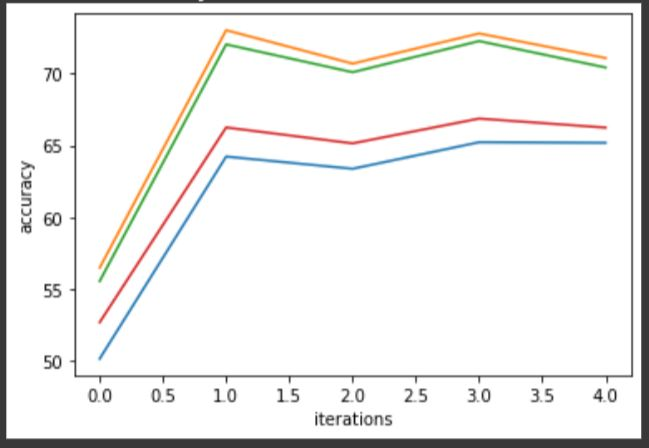

# Test 11-th April: Monte Carlo dropout

In [ ]:
# from https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571

def predict_proba(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.stack(preds).mean(axis=0)
     
def predict_class(X, model, num_samples):
    proba_preds = predict_proba(X, model, num_samples)
    return np.argmax(proba_preds, axis=1)

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_test = X_test.astype('float32') / 255.0

In [ ]:
classification_percentage = 100

In [ ]:
_ = 4
classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"_missingclass/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]

In [ ]:
a_model = classification_models[0] # that should be biased on the class 6
# PAY ATTENTION: the Training=True used for MCD (Monte Carlo Dropout) could affect also the BatchNormalization layers of the model...
image = X_test[0].reshape((1, 32, 32, 3))
predicted_std = a_model.predict(image).reshape((-1))
predicted_10 = predict_proba(image, a_model, 10).reshape((-1))
predicted_100 = predict_proba(image, a_model, 100).reshape((-1))

In [ ]:
print(np.round(predicted_std, 3))
print(np.round(predicted_10, 3))
print(np.round(predicted_100, 3))
print(Y_test[0])

[0.    0.    0.    0.985 0.    0.001 0.012 0.    0.001 0.   ]
[0.016 0.007 0.031 0.075 0.738 0.015 0.059 0.046 0.008 0.006]
[0.013 0.007 0.022 0.059 0.78  0.019 0.046 0.042 0.007 0.006]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [ ]:
real_acc = 0
guessed_classes = [0 for _ in range(10)]
outputs_model = a_model.predict(X_test)
for i in range(len(Y_test)):
    tmp = np.argmax(outputs_model[i])
    if  tmp == Y_test[i]:
        real_acc += 1
        guessed_classes[tmp] += 1
print('accuracy:', real_acc / len(outputs_model))
print('guessed classes:', guessed_classes)

accuracy: 0.6041
guessed classes: [700, 831, 466, 188, 992, 617, 634, 0, 809, 804]


In [ ]:
predicted_classes = predict_class(X_test, a_model, 10)
acc = 0
guessed_classes_mdc = [0 for _ in range(10)]
for i in range(len(predicted_classes)):
    tmp = predicted_classes[i]
    if tmp == Y_test[i]:
        acc += 1
        guessed_classes_mdc[tmp] += 1
print('accuracy:', acc/len(predicted_classes))
print('guessed classes:', guessed_classes_mdc)

accuracy: 0.6762
guessed classes: [766, 856, 526, 519, 978, 634, 778, 0, 874, 831]


In [ ]:
for model in classification_models:
    real_acc = 0
    guessed_classes = [0 for _ in range(10)]
    outputs_model = model.predict(X_test)
    for i in range(len(Y_test)):
        tmp = np.argmax(outputs_model[i])
        if  tmp == Y_test[i]:
            real_acc += 1
            guessed_classes[tmp] += 1
    print('accuracy:', real_acc / len(outputs_model))
    print('guessed classes:', guessed_classes)

accuracy: 0.61
guessed classes: [700, 832, 472, 208, 992, 620, 648, 0, 821, 807]
accuracy: 0.6818
guessed classes: [822, 916, 533, 427, 810, 640, 982, 750, 914, 24]
accuracy: 0.7323
guessed classes: [811, 903, 0, 878, 805, 534, 873, 759, 923, 837]
accuracy: 0.7224
guessed classes: [814, 909, 697, 603, 783, 682, 0, 937, 928, 871]


In [ ]:
# accuracy computation with montecarlo_dropout(10)

In [ ]:
# to modify...
print("Test the " + str(classification_percentage)+"-sparse classification + cheating methods")

montecarlo = []

for _ in range(iterations-1, iterations): # for now, only the last iteration
    print("\n************ Iteration " + str(_) + " ************\n")

    true_average = 0
    true_raw_weights = 0
    true_alpha_weights = 0
    true_softmax_weights = 0
    true_softmax_choice = 0

    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"_missingclass/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]

    eval_images = len(X_test)
    for t in range(eval_images):
        test_img = X_test[t]
        true = np.argmax(Y_test[t])
        
        prediction_vectors = []
        preds_with_raw_weights = []
        for cluster in range(len(clusters)):
            tmp_model = classification_models[cluster]
            pred = tmp_model.predict(test_img.reshape((1, 32, 32, 3))).reshape(-1)
            prediction_vectors.append(pred)

        if np.argmax(sum(prediction_vectors)) == true:
            true_average += 1
        
        weights = [raw_weights[cluster][true] for cluster in range(len(clusters))]
        new_predictions = [prediction_vectors[i]*weights[i] for i in range(len(clusters))]
        if np.argmax(sum(new_predictions)) == true:
            true_raw_weights += 1
        
        weights = [bar_raw_weights[cluster][true] for cluster in range(len(clusters))]
        new_predictions = [prediction_vectors[i]*weights[i] for i in range(len(clusters))]
        if np.argmax(sum(new_predictions)) == true:
            true_alpha_weights += 1

        weights = [softmax_weights[cluster][true] for cluster in range(len(clusters))]
        new_predictions = [prediction_vectors[i]*weights[i] for i in range(len(clusters))]
        if np.argmax(sum(new_predictions)) == true:
            true_softmax_weights += 1

    acc_true_average = true_average / eval_images * 100
    acc_true_raw_weights = true_raw_weights / eval_images * 100
    acc_true_alpha_weights = true_alpha_weights / eval_images * 100
    acc_true_softmax_weights = true_softmax_weights / eval_images * 100

    print('Average accuracy:', acc_true_average)
    print('Raw Weights accuracy:', acc_true_raw_weights)
    print('Alpha Weights accuracy:', acc_true_alpha_weights)
    print('Softmax accuracy:', acc_true_softmax_weights)

    average.append(acc_true_average)
    naive_raw_weights.append(acc_true_raw_weights)
    alpha_weights.append(acc_true_alpha_weights)
    softmax_weights_list.append(acc_true_softmax_weights)
    #softmax_choice.append()

plt.plot(range(iterations), average)
plt.plot(range(iterations), naive_raw_weights)
plt.plot(range(iterations), alpha_weights)
plt.plot(range(iterations), softmax_weights_list)
#plt.plot(range(iterations), )

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

# Test 12-th April: now it works

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
num_classes = len(classes)
X_test = X_test.astype('float32') / 255.0

In [ ]:
classification_percentage = 20
estimation_percentage = 80

In [ ]:
raw_weights = []
for cluster in clusters:
    cluster_labels = cluster.train_data['labels']
    cluster_counts = [0 for _ in range(10)]
    for el in cluster_labels:
        el = np.argmax(el)
        cluster_counts[el] += 1
    raw_weights.append(cluster_counts)

print("Number of images of each class in the local (cluster) training set:")
for i in range(len(raw_weights)):
    print("Cluster " + str(i) + " has " + str(raw_weights[i]))
    print("Bias of the cluster dataset: " + str(np.argmax(raw_weights[i])))
    print("")

Number of images of each class in the local (cluster) training set:
Cluster 0 has [756, 888, 852, 765, 895, 839, 5020, 847, 786, 852]
Bias of the cluster dataset: 6

Cluster 1 has [891, 811, 891, 4944, 837, 773, 870, 849, 831, 803]
Bias of the cluster dataset: 3

Cluster 2 has [779, 810, 818, 879, 839, 873, 867, 4986, 819, 830]
Bias of the cluster dataset: 7

Cluster 3 has [868, 855, 777, 816, 4993, 832, 834, 872, 825, 828]
Bias of the cluster dataset: 4



Test the 20-sparse classification + cheating methods

************ Iteration 0 ************

Accuracy of the model 0: 12.31%
[0, 0, 5, 39, 185, 19, 983, 0, 0, 0]
Observed bias of the model: 6

Accuracy of the model 1: 28.68%
[261, 837, 0, 966, 327, 0, 1, 126, 350, 0]
Observed bias of the model: 3

Accuracy of the model 2: 32.03%
[169, 769, 2, 57, 411, 36, 0, 985, 556, 218]
Observed bias of the model: 7

Accuracy of the model 3: 8.65%
[0, 0, 0, 0, 14, 0, 718, 0, 0, 133]
Observed bias of the model: 6

Accuracy of the averaging: 33.66%
Number of captured classes: [72, 675, 0, 617, 655, 6, 88, 834, 383, 36]

Weight (cheat):
Accuracy of the weighted averaging: 46.41%
Number of captured classes: [81, 654, 0, 938, 755, 11, 799, 976, 389, 38]

************ Iteration 1 ************

Accuracy of the model 0: 42.47%
[346, 951, 137, 215, 900, 262, 811, 212, 413, 0]
Observed bias of the model: 1

Accuracy of the model 1: 53.87%
[620, 965, 0, 780, 661, 453, 478, 591, 306, 533]
Observed bias of the m

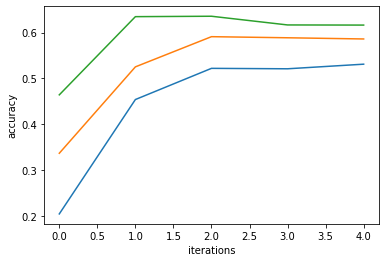

In [ ]:
print("Test the " + str(classification_percentage)+"-sparse classification + cheating methods")

average_accuracies = []
accuracy_of_averaging = []
weighted_accuracies = []

for _ in range(iterations):
    print("\n************ Iteration " + str(_) + " ************\n")

    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"_missingclass/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]

    classification_models = [classification_models[1], classification_models[2], classification_models[3], classification_models[0]] # correction!
    # THIS IS A CORRECTION: I DO NOT KNOW WHY THE MODELS ARE NOT SORTED IN THE LIST!
    # classification_models = [classification_models[1], classification_models[2], classification_models[3], classification_models[0]]
    # with this the order in the list is the order of the clusters: BIAS OF THE i-th MODEL IS THE BIAS OF THE i-th CLUSTER

    softmax_outputs = []
    for model in classification_models:
        softmax_outputs.append(model.predict(X_test))

    m = 0
    tmp_avg_acc = 0
    for predictions in softmax_outputs:
        hist = [0 for j in range(10)]
        tmp_acc = 0
        for i in range(len(predictions)):
            if np.argmax(predictions[i]) == Y_test[i]:
                tmp_acc += 1
                hist[int(Y_test[i])] += 1
        print("Accuracy of the model " + str(m) + ": " + str(100*tmp_acc/len(predictions)) + "%")
        print(hist)
        print("Observed bias of the model: " + str(np.argmax(hist)))
        print("")
        tmp_avg_acc += tmp_acc/len(predictions)
        m += 1   
    average_accuracies.append(tmp_avg_acc/4)

    averaging = sum(softmax_outputs) 
    acc = 0
    hist = [0 for j in range(10)]
    for i in range(len(averaging)):
        if np.argmax(averaging[i]) == Y_test[i]:
            acc += 1
            hist[int(Y_test[i])] += 1
    print("Accuracy of the averaging: " + str(100*acc/len(averaging)) + "%")
    print("Number of captured classes: " + str(hist))
    accuracy_of_averaging.append(acc/len(averaging))

    print("\nWeight (cheat):")
    for i in range(len(Y_test)):
        for j in range(4):
            softmax_outputs[j][i] = raw_weights[j][int(Y_test[i])] * softmax_outputs[j][i]
        
    averaging = sum(softmax_outputs) 
    acc = 0
    hist = [0 for el in range(10)]
    for i in range(len(averaging)):
        if np.argmax(averaging[i]) == Y_test[i]:
            acc += 1
            hist[int(Y_test[i])] += 1
    print("Accuracy of the weighted averaging: " + str(100*acc/len(averaging)) + "%")
    print("Number of captured classes: " + str(hist))
    weighted_accuracies.append(acc/len(averaging))

plt.plot(range(iterations), average_accuracies)
plt.plot(range(iterations), accuracy_of_averaging)
plt.plot(range(iterations), weighted_accuracies)
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

Test the 20-sparse classification + 80-sparse estimation model

************ Iteration 0 ************

Accuracy of the model 0: 12.31%

Accuracy of the model 1: 28.68%

Accuracy of the model 2: 32.03%

Accuracy of the model 3: 8.65%

Accuracy of the averaging: 33.66%

Estimated Marginals:


/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.LogisticDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


Accuracy of the weighted averaging: 15.96%
Number of captured classes: [66, 226, 0, 297, 181, 3, 501, 112, 135, 75]

************ Iteration 1 ************

Accuracy of the model 0: 42.47%

Accuracy of the model 1: 53.87%

Accuracy of the model 2: 49.45%

Accuracy of the model 3: 35.76%

Accuracy of the averaging: 52.52%

Estimated Marginals:
Accuracy of the weighted averaging: 53.87%
Number of captured classes: [620, 965, 0, 780, 661, 453, 478, 591, 306, 533]

************ Iteration 2 ************

Accuracy of the model 0: 52.46%

Accuracy of the model 1: 57.92%

Accuracy of the model 2: 51.51%

Accuracy of the model 3: 46.89%

Accuracy of the averaging: 59.11%

Estimated Marginals:
Accuracy of the weighted averaging: 57.92%
Number of captured classes: [711, 968, 0, 556, 443, 694, 718, 721, 307, 674]

************ Iteration 3 ************

Accuracy of the model 0: 52.97%

Accuracy of the model 1: 57.99%

Accuracy of the model 2: 49.96%

Accuracy of the model 3: 47.48%

Accuracy of the 

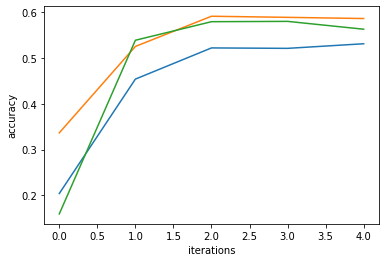

In [ ]:
# TRY WITH THE REAL WEIGHTS (FIND THE ORDER OF THE ESTIMATION MODELS...)

print("Test the " + str(classification_percentage)+"-sparse classification + "+str(estimation_percentage)+"-sparse estimation model")

average_accuracies = []
avg_method = []
weighted_accuracies = []

for _ in range(iterations):
    print("\n************ Iteration " + str(_) + " ************\n")

    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"_missingclass/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]

    classification_models = [classification_models[1], classification_models[2], classification_models[3], classification_models[0]]

    softmax_outputs = []
    for model in classification_models:
        softmax_outputs.append(model.predict(X_test))

    m = 0
    tmp_avg_acc = 0
    for predictions in softmax_outputs:
        hist = [0 for j in range(10)]
        tmp_acc = 0
        for i in range(len(predictions)):
            if np.argmax(predictions[i]) == Y_test[i]:
                tmp_acc += 1
                hist[int(Y_test[i])] += 1
        print("Accuracy of the model " + str(m) + ": " + str(100*tmp_acc/len(predictions)) + "%")
        #print(hist)
        #print("Observed bias of the model: " + str(np.argmax(hist)))
        print("")
        tmp_avg_acc += tmp_acc/len(predictions)
        m += 1   
    average_accuracies.append(tmp_avg_acc/4)

    averaging = sum(softmax_outputs) 
    acc = 0
    hist = [0 for el in range(10)]
    for i in range(len(averaging)):
        if np.argmax(averaging[i]) == Y_test[i]:
            acc += 1
            hist[int(Y_test[i])] += 1
    print("Accuracy of the averaging: " + str(100*acc/len(averaging)) + "%")
    #print("Number of captured classes: " + str(hist))
    avg_method.append(acc/len(averaging))

    print("\nEstimated Marginals:")

    estimation_models = []
    for cluster in clusters:
        tmp_model = NICE(data_dim=3072, num_coupling_layers=3)
        tmp_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"_missingclass/estimation"+str(estimation_percentage)+"/estimation_cluster"+str(cluster.number)+"sparse_"+str(estimation_percentage)+"_iter"+str(_)+".pt"))
        estimation_models.append(tmp_model)

    estimation_models = [estimation_models[1], estimation_models[2], estimation_models[3], estimation_models[0]]
    # try with this

    estimated_weights = []
    for test_img in X_test:
        log_probs = [] # 
        for cluster in range(len(clusters)):
            tmp_est = estimation_models[cluster]
            log_prob = tmp_est.forward(torch.from_numpy(test_img.reshape((3072))).float())[1]-tmp_est.f(torch.from_numpy(test_img.reshape((3072))).float())[1]
            log_probs.append(log_prob.detach().numpy().reshape((-1)))
        comp = float(max(log_probs)) + np.log(sum(np.exp([float(el-float(max(log_probs))) for el in log_probs])))
        alpha = [np.exp(el-comp) for el in log_probs]
        estimated_weights.append(alpha)
    
    ''' to see
    for i in range(len(X_test)): # faccio solo con i bias per ora
        estimated_weights[i] = [float(el) for el in estimated_weights[i]]
        if Y_test[i] in [4, 6, 3, 7]:
            print("Label = " + str(int(Y_test[i])))
            print("Weight of the estimated marginal = " + str(np.argmax(estimated_weights[i])))
    '''

    for i in range(len(Y_test)):
        for j in range(4):
            softmax_outputs[j][i] = estimated_weights[i][j] * softmax_outputs[j][i]
        
    averaging = sum(softmax_outputs) 
    acc = 0
    hist = [0 for el in range(10)]
    for i in range(len(averaging)):
        if np.argmax(averaging[i]) == Y_test[i]:
            acc += 1
            hist[int(Y_test[i])] += 1
    print("Accuracy of the weighted averaging: " + str(100*acc/len(averaging)) + "%")
    print("Number of captured classes: " + str(hist))
    weighted_accuracies.append(acc/len(averaging))

plt.plot(range(iterations), average_accuracies) # average local
plt.plot(range(iterations), avg_method)
plt.plot(range(iterations), weighted_accuracies)
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

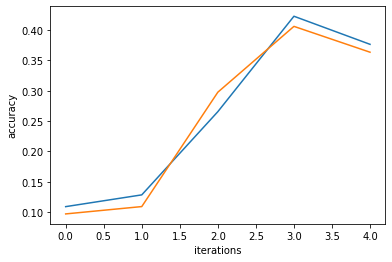

In [ ]:
plt.plot(range(iterations), avg_method)
plt.plot(range(iterations), weighted_accuracies)
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

# Other Tests

## Match of the flow.

In [ ]:
print("Estimation model with " + str(estimation_percentage) + " sparsification.")

for _ in range(iterations):
    print("\n************ Iteration " + str(_) + " ************")

    match = 0
    check = 0

    estimation_models = []
    for cluster in clusters:
        tmp_model = NICE(data_dim=3072, num_coupling_layers=3)
        tmp_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"_missingclass/estimation"+str(estimation_percentage)+"/estimation_cluster"+str(cluster.number)+"sparse_"+str(estimation_percentage)+"_iter"+str(_)+".pt"))
        estimation_models.append(tmp_model)

    eval_images = len(X_test)

    for t in range(eval_images):
        test_img = X_test[t]
        true = np.argmax(Y_test[t])

        if true in fav_classes:
            check += 1
            prediction_vectors = []
            log_probs = []

            for cluster in range(len(clusters)):
                #tmp_model = classification_models[cluster]
                tmp_est = estimation_models[cluster]
                log_prob = tmp_est.forward(torch.from_numpy(test_img.reshape((3072))).float())[1]-tmp_est.f(torch.from_numpy(test_img.reshape((3072))).float())[1]
                log_probs.append(log_prob.detach().numpy().reshape((-1)))
                #pred = tmp_model.predict(test_img.reshape((1, 32, 32, 3)))
                #prediction_vectors.append(pred.reshape(-1))
            
            comp = float(max(log_probs)) + np.log(sum(np.exp([float(el-float(max(log_probs))) for el in log_probs])))
            alpha = [np.exp(el-comp) for el in log_probs]
            if fav_classes[np.argmax(alpha)] == true:
                match += 1
    print("Match of the normalizing flow = " + str(match/check*100))

Estimation model with 100 sparsification.

************ Iteration 0 ************


/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.LogisticDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


Match of the normalizing flow = 24.099999999999998

************ Iteration 1 ************
Match of the normalizing flow = 25.900000000000002

************ Iteration 2 ************
Match of the normalizing flow = 28.599999999999998

************ Iteration 3 ************
Match of the normalizing flow = 30.4

************ Iteration 4 ************
Match of the normalizing flow = 28.325


In [ ]:
''' HETEROGENEITY 0.4 AND MISSING CLASS
Estimation model with 100 sparsification.

************ Iteration 0 ************
/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.LogisticDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')
Match of the normalizing flow = 24.099999999999998

************ Iteration 1 ************
Match of the normalizing flow = 25.900000000000002

************ Iteration 2 ************
Match of the normalizing flow = 28.599999999999998

************ Iteration 3 ************
Match of the normalizing flow = 30.4

************ Iteration 4 ************
Match of the normalizing flow = 28.325

so it is still low, and tends to deteriorate, but it is sufficient to increase the overall accuracy in presence of very high heterogeneity
'''

In [ ]:
''' WITHOUT MISSING CLASS:
Estimation model with 100 sparsification.

************ Iteration 0 ************
/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.LogisticDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')
Match of the normalizing flow = 24.099999999999998

************ Iteration 1 ************
Match of the normalizing flow = 27.500000000000004

************ Iteration 2 ************
Match of the normalizing flow = 30.375000000000004

************ Iteration 3 ************
Match of the normalizing flow = 34.025

************ Iteration 4 ************
Match of the normalizing flow = 32.2

CONCLUSIONS: increase the accuracy of the normalizing flow!!
'''

" WITHOUT MISSING CLASS:\nEstimation model with 100 sparsification.\n\n************ Iteration 0 ************\n/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.LogisticDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.\n  'with `validate_args=False` to turn off validation.')\nMatch of the normalizing flow = 24.099999999999998\n\n************ Iteration 1 ************\nMatch of the normalizing flow = 27.500000000000004\n\n************ Iteration 2 ************\nMatch of the normalizing flow = 30.375000000000004\n\n************ Iteration 3 ************\nMatch of the normalizing flow = 34.025\n\n************ Iteration 4 ************\nMatch of the normalizing flow = 32.2\n\nCONCLUSIONS: increase the accuracy of the normalizing flow!!\n"

## Test how NN works for different clusters and some images

In [ ]:
print("Test the " + str(classification_percentage)+"-sparse classification + "+str(estimation_percentage)+"-sparse estimation model\n")


for _ in range(iterations-1, iterations): # since the output is huge, I compute it only for the last iteration
    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"_missingclass/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]

    eval_images = 45 #len(X_test)

    for t in range(eval_images):
        test_img = X_test[t]
        true = np.argmax(Y_test[t])
        print("\n\n******** Image number " + str(t) + " of the test set. Label: " + str(true) + " ********")

        if true in fav_classes:
            print("(This is in fav_classes, so one cluster has to be strongly sure about its prediction!)\n")
        
        prediction_vectors = []
        #log_probs = []
        for cluster in range(len(clusters)):
            tmp_model = classification_models[cluster]
            #tmp_est = estimation_models[cluster]
            #log_prob = tmp_est.forward(torch.from_numpy(test_img.reshape((3072))).float())[1]-tmp_est.f(torch.from_numpy(test_img.reshape((3072))).float())[1]
            #log_probs.append(log_prob.detach().numpy().reshape((-1)))
            pred = tmp_model.predict(np.expand_dims(test_img, axis=0)).reshape(-1)
            print(str(cluster) +") Softmax of cnn of cluster " + str(cluster) + " is ", end='')
            s = ""
            for el in pred:
                s += str("%.2f" % el) + ", "
            print("[" + s[:len(s)-2] + "]", end='')
            print(", prediction = " + str(np.argmax(pred)))
            prediction_vectors.append(pred)
        
        if np.argmax(sum(prediction_vectors)) == true:
            print("(In this case the average prediction is right.)")

Test the 100-sparse classification + 100-sparse estimation model



******** Image number 0 of the test set. Label: 3 ********
(This is in fav_classes, so one cluster has to be strongly sure about its prediction!)

0) Softmax of cnn of cluster 0 is [0.00, 0.00, 0.00, 0.99, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00], prediction = 3
1) Softmax of cnn of cluster 1 is [0.00, 0.00, 0.00, 0.45, 0.00, 0.00, 0.53, 0.00, 0.02, 0.00], prediction = 6
2) Softmax of cnn of cluster 2 is [0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00], prediction = 3
3) Softmax of cnn of cluster 3 is [0.00, 0.00, 0.00, 0.91, 0.00, 0.00, 0.00, 0.00, 0.09, 0.00], prediction = 3
(In this case the average prediction is right.)


******** Image number 1 of the test set. Label: 8 ********
0) Softmax of cnn of cluster 0 is [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00], prediction = 8
1) Softmax of cnn of cluster 1 is [0.00, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.98, 0.00], prediction = 8
2) Softmax

## Test again the behaviour of the networks, on 100 and 50 % sparsified, and plot the average errors.

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
num_classes = len(classes)
X_test = X_test.astype('float32') / 255.0
Y_test = to_categorical(Y_test, num_classes)

In [ ]:
to_plot_locals = []
to_plot_originals = []
for classification_percentage in [50, 100]:

    local = []
    original = []

    for _ in range(iterations):
        print("\n\n*** Iteration " + str(_))
        name_1 = "/content/drive/MyDrive/Colab Notebooks/heterogeneity" + str(int(bias_factor*100)) + "/classification" + str(classification_percentage) + "/cluster"
        name_3 = "_" + str(classification_percentage) + "sparse_iter" + str(_) + ".h5"
        classification_models = [tf.keras.models.load_model(name_1+str(cluster.number)+name_3) for cluster in clusters]

        tmp_local = 0
        tmp_original = 0

        for _ in range(len(clusters)):
            print("\nCluster number " + str(_) + ":")
            loss, accuracy = classification_models[_].evaluate(clusters[_].test_data['images'], clusters[_].test_data['labels'], verbose=0)
            print("Accuracy on the local test set = " + str(accuracy))
            tmp_local += accuracy/len(clusters)
            loss, accuracy = classification_models[_].evaluate(X_test, Y_test, verbose=0)
            print("Accuracy on the original test set = " + str(accuracy))
            tmp_original += accuracy/len(clusters)

        local.append(tmp_local)
        original.append(tmp_original)
    
    to_plot_locals.append(local)
    to_plot_originals.append(original)
    
for _ in range(3):
    plt.plot(range(iterations), to_plot_locals[_])
    plt.plot(range(iterations), to_plot_originals[_])
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

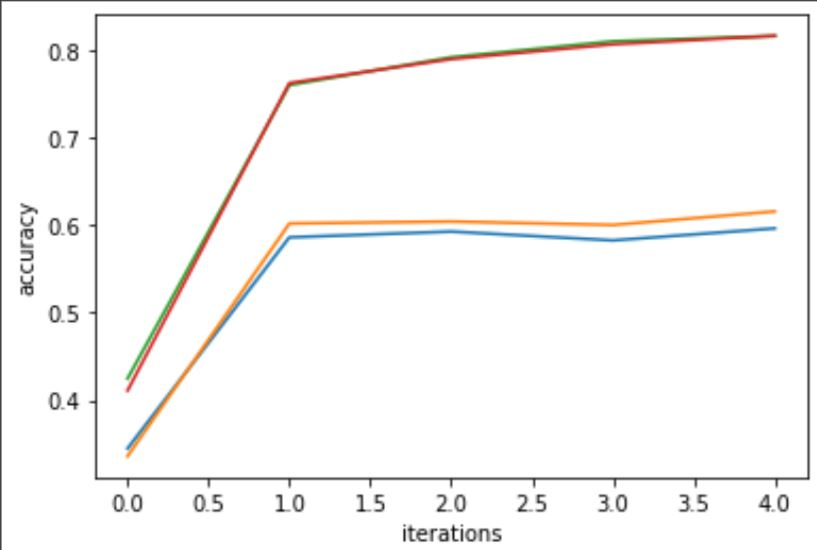

- 100 sparse: there is not a remarkable difference between local and global test set. The heterogeneity is not enough! It must perform well in its local dataset and worst in the global... i think.

- 50 sparse: the accuracy is quite lower but the difference between local and global performances is increased. This is because of the sparsification, not the heterogeneity! 

## Understand the differences between averaging and hybrid models ONLY on fav_classes and missing_classes.

In [ ]:
print("Test the " + str(classification_percentage)+"-sparse classification + "+str(estimation_percentage)+"-sparse estimation model\n")


for _ in range(iterations-1, iterations): # since the output is huge, I compute it only for the last iteration
    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"_missingclass/classification"+str(classification_percentage)+"/cluster"+
                                                        str(cluster.number)+"_"+str(classification_percentage)+"sparse_iter"+
                                                        str(_)+".h5") for cluster in clusters]
    estimation_models = []
    for cluster in clusters:
        tmp_model = NICE(data_dim=3072, num_coupling_layers=3)
        tmp_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/heterogeneity"+str(int(bias_factor*100))+"_missingclass/estimation"+str(estimation_percentage)+"/estimation_cluster"+str(cluster.number)+"sparse_"+str(estimation_percentage)+"_iter"+str(_)+".pt"))
        estimation_models.append(tmp_model)

    eval_images = len(X_test)

    for t in range(eval_images):
        test_img = X_test[t]
        true = np.argmax(Y_test[t])
        #print("\n\n******** Image number " + str(t) + " of the test set. Label: " + str(true) + " ********")

        #if true in fav_classes:
            #print("(This is in fav_classes, so the cluster number " + str(fav_classes.index(true)) + " has to be strongly sure about its prediction!)")
        #if true in not_wanted_classes:
            #print("(This is a not wanted class, so the cluster number " + str(not_wanted_classes.index(true)) + " has to be quite unsure about its prediction!)\n")
        
        prediction_vectors = []
        log_probs = []
        for cluster in range(len(clusters)):
            tmp_model = classification_models[cluster]
            tmp_est = estimation_models[cluster]
            log_prob = tmp_est.forward(torch.from_numpy(test_img.reshape((3072))).float())[1]-tmp_est.f(torch.from_numpy(test_img.reshape((3072))).float())[1]
            log_probs.append(log_prob.detach().numpy().reshape((-1)))
            pred = tmp_model.predict(np.expand_dims(test_img, axis=0)).reshape(-1)
            #print(str(cluster) +") Softmax of cnn of cluster " + str(cluster) + " is ", end='')
            s = ""
            for el in pred:
                s += str("%.2f" % el) + ", "
            #print("[" + s[:len(s)-2] + "]", end='')
            #print(", prediction = " + str(np.argmax(pred)))
            prediction_vectors.append(pred)
        
        comp = float(max(log_probs)) + np.log(sum(np.exp([float(el-float(max(log_probs))) for el in log_probs])))
        alpha = [np.exp(el-comp) for el in log_probs]
        predicted = np.argmax(sum([alpha[i]*prediction_vectors[i] for i in range(len(clusters))]))

        if (not np.argmax(sum(prediction_vectors)) == true) and (predicted == true):
            print("(In image number " + str(t) + " ONLY the hybrid prediction is right.)")

Test the 100-sparse classification + 100-sparse estimation model



/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.LogisticDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


(In image number 61 ONLY the hybrid prediction is right.)
(In image number 116 ONLY the hybrid prediction is right.)
(In image number 143 ONLY the hybrid prediction is right.)
(In image number 145 ONLY the hybrid prediction is right.)
(In image number 213 ONLY the hybrid prediction is right.)
(In image number 306 ONLY the hybrid prediction is right.)
(In image number 323 ONLY the hybrid prediction is right.)
(In image number 397 ONLY the hybrid prediction is right.)
(In image number 412 ONLY the hybrid prediction is right.)
(In image number 470 ONLY the hybrid prediction is right.)
(In image number 637 ONLY the hybrid prediction is right.)
(In image number 669 ONLY the hybrid prediction is right.)
(In image number 671 ONLY the hybrid prediction is right.)
(In image number 676 ONLY the hybrid prediction is right.)
(In image number 690 ONLY the hybrid prediction is right.)
(In image number 735 ONLY the hybrid prediction is right.)
(In image number 792 ONLY the hybrid prediction is right.

## Test the median instead of averaging 
(Note that with an even number of clusters the median is the average of the two central values...)

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_test = X_test.astype('float32') / 255.0

spars = 50

classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/FederatedLearning/heterogeneity"+str(int(0.4*100))+"_missingclass/classification"+str(spars)+"/cluster"+
                                                        str(cluster.number)+"_"+str(spars)+"sparse_iter"+
                                                        str(iteration)+".h5") for cluster in clusters]

softmax_outputs = []
for model in classification_models:
    softmax_outputs.append(model.predict(X_test))

# averaging
averaging = sum(softmax_outputs) 
acc = 0
for i in range(len(averaging)):
    if np.argmax(averaging[i]) == Y_test[i]:
        acc += 1
print("Accuracy of the averaging: " + str(100*acc/len(averaging)) + "%")

# median
from statistics import median
predictions = []
for i in range(softmax_outputs[0].shape[0]):
    fir, sec, thi, fort = [softmax_outputs[j][i] for j in range(4)]
    tmp_soft = []
    for j in range(10):
        tmp_soft.append(median([fir[j], sec[j], thi[j], fort[j]]))
    predictions.append(np.argmax(tmp_soft))

acc = 0
for i in range(len(predictions)):
    if predictions[i] == Y_test[i]:
        acc += 1
print("Accuracy of the median: " + str(100*acc/len(predictions)) + "%")

Accuracy of the averaging: 65.19%
Accuracy of the median: 65.2%


## Voting rule

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_test = X_test.astype('float32') / 255.0

spars = 100
iteration = 4
classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/FederatedLearning/heterogeneity"+str(int(0.4*100))+"/classification"+str(spars)+"/cluster"+
                                                        str(cluster.number)+"_"+str(spars)+"sparse_iter"+
                                                        str(iteration)+".h5") for cluster in clusters]

softmax_outputs = []
for model in classification_models:
    softmax_outputs.append(model.predict(X_test))

averaging = sum(softmax_outputs) 
acc = 0
for i in range(len(averaging)):
    if np.argmax(averaging[i]) == Y_test[i]:
        acc += 1
print("Accuracy of the averaging: " + str(100*acc/len(averaging)) + "%")

acc = 0
for i in range(len(softmax_outputs[0])):
    selection = [max(softmax_outputs[j][i]) for j in range(4)]
    to_listen = softmax_outputs[np.argmax(selection)][i]
    if np.argmax(to_listen) == Y_test[i]:
        acc += 1

print("Accuracy of the voting: " + str(100*acc/len(softmax_outputs[0])) + "%")

# conclusion: non sempre bisogna ascoltare il più sicuro 

Accuracy of the averaging: 79.82%
Accuracy of the voting: 78.94%


# May 2021: combiners with data at server side

In [ ]:
import random
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

number_of_server_images = 500
X_test = X_test.astype('float32') / 255.0

server_images = np.zeros((number_of_server_images, 32, 32, 3))
server_labels = []

i = 0
for _ in range(number_of_server_images):
    index = random.randint(0, len(X_test)-1)
    server_images[i] = X_test[index] # random image
    server_labels.append(Y_test[index])
    # there is a probability that the same test image is picked twice
    i += 1
'''
i = 0
c = 0
while i < number_of_server_images:
    if not Y_test[c] in [3, 4, 6, 7]:
        server_images[i] = X_test[c]
        server_labels.append(Y_test[c])
        i += 1
    c += 1
'''

server_images_train = server_images[:int(3*len(server_labels)/4)]
server_images_validation = server_images[int(3*len(server_labels)/4):]
server_labels_train = to_categorical(np.asarray(server_labels[:int(3*len(server_labels)/4)]), 10)
server_labels_validation = to_categorical(np.asarray(server_labels[int(3*len(server_labels)/4):]), 10)

# load the models
# try with different iterations
iteration = 4
spars = 100
classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/FederatedLearning/heterogeneity"+str(int(0.4*100))+"/classification"+str(spars)+"/cluster"+
                                                        str(cluster.number)+"_"+str(spars)+"sparse_iter"+
                                                        str(iteration)+".h5") for cluster in clusters]

# produce the cluster outputs
softmax_train_outputs = []
softmax_validation_outputs = []
for cluster_model in classification_models:
    softmax_train_outputs.append(cluster_model.predict(server_images_train))
    softmax_validation_outputs.append(cluster_model.predict(server_images_validation))
softmax_clusters_train = []
softmax_clusters_validation = []
for i in range(int(number_of_server_images*0.75)):
    temp = np.zeros((4, 10))
    for j in range(4):
        temp[j] = softmax_train_outputs[j][i]
    softmax_clusters_train.append(temp)
softmax_clusters_train = np.asarray(softmax_clusters_train)
for i in range(int(number_of_server_images*0.25)):
    temp = np.zeros((4, 10))
    for j in range(4):
        temp[j] = softmax_validation_outputs[j][i]
    softmax_clusters_validation.append(temp)
softmax_clusters_validation = np.asarray(softmax_clusters_validation)

In [ ]:
def prova2(): # a naive model

    input = tf.keras.layers.Input(shape=(4, 10), name="input_softmax_clusters")
    image = tf.keras.layers.Input(shape=(32, 32, 3), name="input_image")

    reshaped_image = tf.keras.layers.Reshape((1, 32, 32, 3,), name="reshape_image_for_conv")(image)
    reshaped_input = tf.keras.layers.Reshape((1, 4, 10), name="reshape_input")(input)

    # this is to compress the image in order to obtain the key
    y = tf.keras.layers.Conv2D(3, 3, name="first_conv_layer")(reshaped_image)
    y = tf.keras.layers.Conv2D(3, 3, name="second_conv_layer")(y)
    y = tf.keras.layers.Reshape((28, 28, 3), name="intermediate_reshape")(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="first_max_pooling")(y)
    y = tf.keras.layers.Conv2D(3, 3, name="third_conv_layer")(y)
    y = tf.keras.layers.Conv2D(3, 3, name="fourth_conv_layer")(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Conv2D(3, 3, name="fifth_conv_layer")(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="second_max_pooling")(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(48, activation='relu')(y)
    y = tf.keras.layers.Reshape((4, 4, 3))(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="third_max_pooling")(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Flatten(name="intermediate_flatten")(y)
    y = tf.keras.layers.Dense(10)(y)

    # once we have obtained the compress image...
    resized_image = tf.keras.layers.Reshape((1, 1, 10), name="resized_compressed_image")(y)
    # we can perform the key-query multiplication
    matmul = tf.keras.layers.dot([resized_image, reshaped_input], 3, name="first_dot_product")
    # now, instead doing the softmax, we obtain the final weights through a Dense layer (a learnable matrix)
    matmul = tf.keras.layers.Flatten(name="flatten_weights")(matmul)
    weights = tf.keras.layers.Dense(4, activation='softmax')(matmul)

    final = tf.keras.layers.dot([weights, input], 1, name="matrix_multimplication_for_output")
    final = tf.keras.layers.Flatten(name="output")(final)

    model = tf.keras.models.Model(inputs=[input, image], outputs=final, name="custom_model")

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model

In [ ]:
def prova3(): 

    input = tf.keras.layers.Input(shape=(4, 10), name="input_softmax_clusters")
    image = tf.keras.layers.Input(shape=(32, 32, 3), name="input_image")

    reshaped_image = tf.keras.layers.Reshape((1, 32, 32, 3,), name="reshape_image_for_conv")(image)
    reshaped_input = tf.keras.layers.Reshape((1, 4, 10), name="reshape_input")(input)

    # this is to compress the image in order to obtain the key
    y = tf.keras.layers.Conv2D(3, 3, activation='relu', name="first_conv_layer")(reshaped_image)
    y = tf.keras.layers.Conv2D(3, 3, activation='relu', name="second_conv_layer")(y)
    y = tf.keras.layers.Reshape((28, 28, 3), name="intermediate_reshape")(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="first_max_pooling")(y)
    y = tf.keras.layers.Conv2D(3, 3, activation='relu', name="third_conv_layer")(y)
    y = tf.keras.layers.Conv2D(3, 3, activation='relu', name="fourth_conv_layer")(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Conv2D(3, 3, activation='relu', name="fifth_conv_layer")(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="second_max_pooling")(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="third_max_pooling")(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Flatten(name="intermediate_flatten")(y)
    y = tf.keras.layers.Dense(10, activation='relu')(y)

    # once we have obtained the compress image...
    resized_image = tf.keras.layers.Reshape((1, 1, 10), name="resized_compressed_image")(y)
    # we can perform the key-query multiplication
    matmul = tf.keras.layers.dot([resized_image, reshaped_input], 3, name="first_dot_product")
    # now, instead doing the softmax, we obtain the final weights through a Dense layer (a learnable matrix)
    matmul = tf.keras.layers.Flatten(name="flatten_weights")(matmul)
    weights = tf.keras.layers.Dense(4, activation='relu')(matmul) # nothing
    weights = tf.keras.layers.Dense(4, activation='relu')(weights)
    weights = tf.keras.layers.Dense(4)(weights)

    final = tf.keras.layers.dot([weights, input], 1, name="matrix_multimplication_for_output")
    final = tf.keras.layers.Flatten(name="output")(final)
    final = tf.keras.layers.Dense(10, activation='softmax')(final)
    model = tf.keras.models.Model(inputs=[input, image], outputs=final, name="custom_model")

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model

In [ ]:
def prova4():

    input = tf.keras.layers.Input(shape=(4, 10), name="input_softmax_clusters")
    image = tf.keras.layers.Input(shape=(32, 32, 3), name="input_image")

    #reshaped_image = tf.keras.layers.Reshape((1, 32, 32, 3,), name="reshape_image_for_conv")(image)
    reshaped_input = tf.keras.layers.Reshape((1, 4, 10), name="reshape_input")(input)

    # this is to compress the image in order to obtain the key
    y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3))(image)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.3)(y)
    y = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.5)(y)
    y = tf.keras.layers.Dense(10, activation='relu')(y) # softmax

    # once we have obtained the compress image...
    resized_image = tf.keras.layers.Reshape((1, 1, 10), name="resized_compressed_image")(y)
    # we can perform the key-query multiplication
    matmul = tf.keras.layers.dot([resized_image, reshaped_input], 3, name="first_dot_product")
    # now, instead doing the softmax, we obtain the final weights through a Dense layer (a learnable matrix)
    matmul = tf.keras.layers.Flatten(name="flatten_weights")(matmul)
    weights = tf.keras.layers.Dense(4, activation='relu')(matmul)

    final = tf.keras.layers.dot([weights, input], 1, name="matrix_multimplication_for_output")
    final = tf.keras.layers.Flatten(name="output")(final)
    final = tf.keras.layers.Softmax()(final)
    model = tf.keras.models.Model(inputs=[input, image], outputs=final, name="custom_model")

    opt = Adam(lr=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model

In [ ]:
def att(n):

    input = tf.keras.layers.Input(shape=(4, 10), name="input_softmax_clusters")
    image = tf.keras.layers.Input(shape=(32, 32, 3), name="input_image")

    #flatten_image = tf.keras.layers.Flatten()(image)
    #query = tf.keras.layers.Conv1D(filters=n, kernel_size=4, padding='same')(image)
    #query = tf.keras.layers.Dense(n)(flatten_image)

    # this is to compress the image in order to obtain the key
    y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3))(image)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.3)(y)
    y = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.5)(y)
    query = tf.keras.layers.Dense(n)(y)

    flatten_input = tf.keras.layers.Flatten()(input)
    key = tf.keras.layers.Dense(n)(flatten_input)

    value = tf.keras.layers.Dense(n)(flatten_input)

    attention = tf.keras.layers.Attention()([query, value, key])
    final = tf.keras.layers.Dense(10, activation='softmax')(attention)
    
    model = tf.keras.models.Model(inputs=[input, image], outputs=final)

    opt = Adam(lr=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
def head(input, image, n):
    
    y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3))(image)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.3)(y)
    y = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    query = tf.keras.layers.Dropout(0.5)(y)
    
    '''
    flatten_image = tf.keras.layers.Flatten()(image)
    query = tf.keras.layers.Dense(n, activation='relu')(flatten_image)
    query = tf.keras.layers.Dense(n, activation='relu')(query)
    '''

    query = tf.keras.layers.Dense(n)(query)

    flatten_input = tf.keras.layers.Flatten()(input)
    key = tf.keras.layers.Dense(n)(flatten_input)
    key = tf.keras.layers.Dropout(0.2)(key)

    value = tf.keras.layers.Dense(n)(flatten_input)
    value = tf.keras.layers.Dropout(0.2)(value)

    head = tf.keras.layers.Attention()([query, value, key])
    return head

In [ ]:
def multihead(hidden_dimension, number_of_heads):

    input = tf.keras.layers.Input(shape=(4, 10), name="input_softmax_clusters")
    image = tf.keras.layers.Input(shape=(32, 32, 3), name="input_image")

    heads = [head(input, image, hidden_dimension) for _ in range(number_of_heads)]
    conc = tf.keras.layers.Concatenate()(heads)
    conc = tf.keras.layers.Dropout(0.3)(conc)
    final = tf.keras.layers.Dense(hidden_dimension, #activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l1(0.001),
                              activity_regularizer=tf.keras.regularizers.l2(0.001))(conc)
    final = tf.keras.layers.Dense(10, activation='softmax')(final)
    model = tf.keras.models.Model(inputs=[input, image], outputs=final)

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()
    plot_model(model, to_file='plotmodel.png', show_shapes=True, show_layer_names=True)
    return model

In [ ]:
def another_try():
    input = tf.keras.layers.Input(shape=(4, 10), name="input_softmax_clusters")
    image = tf.keras.layers.Input(shape=(32, 32, 3), name="input_image")

    y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3))(image)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.3)(y)
    y = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.5)(y)
    coeffs = tf.keras.layers.Dense(4)(y)
    coeffs = tf.keras.layers.BatchNormalization()(coeffs)

    final = tf.keras.layers.dot([coeffs, input], 1, name="linear")
    final = tf.keras.layers.Softmax()(final)
    final = tf.keras.layers.Dense(10, activation='softmax')(final)
    model = tf.keras.models.Model(inputs=[input, image], outputs=final)
    opt = Adam(lr=0.01) # 0.01
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model

In [ ]:
def only_outputs():
    input = tf.keras.layers.Input(shape=(4, 10), name="input_softmax_clusters")
    flatten = tf.keras.layers.Flatten()(input)
    final = tf.keras.layers.Dense(10, activation=None, use_bias=False)(flatten)
    final = tf.keras.layers.Dense(10, activation=None, use_bias=False)(final)
    final = tf.keras.layers.Dense(10, activation=None, use_bias=False)(final)
    final = tf.keras.layers.Dense(10, activation=None, use_bias=False)(final)
    final = tf.keras.layers.Dense(10, activation=None, use_bias=False)(final)
    final = tf.keras.layers.BatchNormalization()(final)
    final = tf.keras.layers.Dense(10, activation='softmax')(final)
    model = tf.keras.models.Model(inputs=input, outputs=final)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=100, decay_rate=0.5)
    opt = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def learn_mask():
    image = tf.keras.layers.Input(shape=(32, 32, 3), name="input_image")

    y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3))(image)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.3)(y)
    y = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.MaxPooling2D((2, 2))(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.5)(y)
    coeffs = tf.keras.layers.Dense(4, activation='softmax')(y)
    mask = tf.keras.layers.BatchNormalization()(coeffs)
    model = tf.keras.models.Model(inputs=image, outputs=mask)
    opt = Adam(lr=0.0001) 
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model

In [ ]:
raw_weights = []
for cluster in clusters:
    cluster_labels = cluster.train_data['labels']
    cluster_counts = [0 for _ in range(10)]
    for el in cluster_labels:
        el = np.argmax(el)
        cluster_counts[el] += 1
    raw_weights.append(cluster_counts)

print("Number of images of each class in the local (cluster) training set:")
for i in range(len(raw_weights)):
    print("Cluster " + str(i) + " has " + str(raw_weights[i]))
    print("Bias of the cluster dataset: " + str(np.argmax(raw_weights[i])))
    print("")

iteration = 4
spars = 100
classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/FederatedLearning/heterogeneity"+str(int(0.4*100))+"/classification"+str(spars)+"/cluster"+
                                                        str(cluster.number)+"_"+str(spars)+"sparse_iter"+
                                                        str(iteration)+".h5") for cluster in clusters]

classification_models = [classification_models[1], classification_models[2], classification_models[3], classification_models[0]] # correction!
# THIS IS A CORRECTION: I DO NOT KNOW WHY THE MODELS ARE NOT SORTED IN THE LIST!
# classification_models = [classification_models[1], classification_models[2], classification_models[3], classification_models[0]]
# with this the order in the list is the order of the clusters: BIAS OF THE i-th MODEL IS THE BIAS OF THE i-th CLUSTER

# prepare the masks to learn
train_masks = []
for el in server_labels_train:
    tmp = [raw_weights[j][int(np.argmax(el))] for j in range(4)]
    max_value = max(tmp)
    max_index = tmp.index(max_value) 
    train_masks.append(to_categorical(max_index, 4))
train_masks = np.asarray(train_masks)

val_masks = []
for el in server_labels_validation:
    tmp = [raw_weights[j][int(np.argmax(el))] for j in range(4)]
    max_value = max(tmp)
    max_index = tmp.index(max_value) 
    val_masks.append(to_categorical(max_index, 4))
val_masks = np.asarray(val_masks)

Number of images of each class in the local (cluster) training set:
Cluster 0 has [756, 888, 852, 765, 895, 839, 5020, 847, 786, 852]
Bias of the cluster dataset: 6

Cluster 1 has [891, 811, 891, 4944, 837, 773, 870, 849, 831, 803]
Bias of the cluster dataset: 3

Cluster 2 has [779, 810, 818, 879, 839, 873, 867, 4986, 819, 830]
Bias of the cluster dataset: 7

Cluster 3 has [868, 855, 777, 816, 4993, 832, 834, 872, 825, 828]
Bias of the cluster dataset: 4



In [ ]:
custom_model = learn_mask()

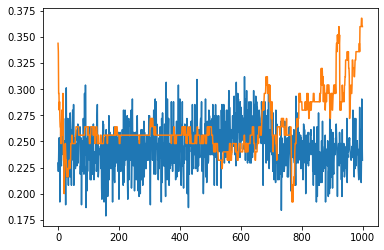

In [ ]:
epochs = 1000
#history = custom_model.fit([softmax_clusters_train, server_images_train], server_labels_train, epochs=epochs, verbose=0, validation_data=([softmax_clusters_validation, server_images_validation], server_labels_validation))
#history = custom_model.fit(softmax_clusters_train, server_labels_train, epochs=epochs, verbose=0, validation_data=(softmax_clusters_validation, server_labels_validation))
history = custom_model.fit(server_images_train, train_masks, epochs=epochs, verbose=0, validation_data=(server_images_validation, val_masks))

plt.figure()
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])

In [ ]:
softmax_outputs = []
for model in classification_models:
    softmax_outputs.append(model.predict(X_test))

averaging = sum(softmax_outputs) 
acc = 0
for i in range(len(averaging)):
    if np.argmax(averaging[i]) == Y_test[i]:
        acc += 1
print("Accuracy of the averaging: " + str(100*acc/len(averaging)) + "%")

to_give = []
for i in range(len(X_test)):
    temp = np.zeros((4, 10))
    for j in range(4):
        temp[j] = softmax_outputs[j][i]
    to_give.append(temp)
to_give = np.asarray(to_give)

_, accuracy = custom_model.evaluate([to_give, X_test], to_categorical(Y_test, 10))
print('Accuracy of the combiner is', accuracy)

Accuracy of the averaging: 79.82%
313/313 [==============================] - 7s 19ms/step - loss: 3.7565 - accuracy: 0.4561
Accuracy of the combiner is 0.4560999870300293


## Less important

In [ ]:
# compute the per class accuracy: evaluate the difference between the favourite and non-favourite classes
# with averaging

list_of_class_members = [[] for _ in range(10)]
for i in range(len(averaging)):
    list_of_class_members[int(Y_test[i])].append(averaging[i])

for i in range(len(list_of_class_members)):
    acc = 0
    for el in list_of_class_members[i]:
        if np.argmax(el) == i:
            acc += 1
    print("Accuracy of class " + str(i) + ": " + str(acc/len(list_of_class_members[i])))
print('')

# with combiner
softmax_outputs = []
for model in classification_models:
    softmax_outputs.append(model.predict(X_test))
to_give = []
for i in range(len(X_test)):
    temp = np.zeros((4, 10))
    for j in range(4):
        temp[j] = softmax_outputs[j][i]
    to_give.append(temp)
to_give = np.asarray(to_give)

print("COMBINER:")

combiner_predictions = custom_model.predict([to_give, X_test])
#combiner_predictions = custom_model.predict(to_give) # when the model does not need the images

list_of_class_members = [[] for _ in range(10)]
for i in range(len(combiner_predictions)):
    list_of_class_members[int(Y_test[i])].append(combiner_predictions[i])

for i in range(len(list_of_class_members)):
    acc = 0
    for el in list_of_class_members[i]:
        if np.argmax(el) == i:
            acc += 1
    print("Accuracy of class " + str(i) + ": " + str(acc/len(list_of_class_members[i])))

print('Number of images per class')
print([len(list_of_class_members[i]) for i in range(10)])

Accuracy of class 0: 0.782
Accuracy of class 1: 0.878
Accuracy of class 2: 0.608
Accuracy of class 3: 0.624
Accuracy of class 4: 0.853
Accuracy of class 5: 0.668
Accuracy of class 6: 0.938
Accuracy of class 7: 0.848
Accuracy of class 8: 0.899
Accuracy of class 9: 0.884

COMBINER:
Accuracy of class 0: 0.798
Accuracy of class 1: 0.912
Accuracy of class 2: 0.659
Accuracy of class 3: 0.685
Accuracy of class 4: 0.834
Accuracy of class 5: 0.668
Accuracy of class 6: 0.902
Accuracy of class 7: 0.847
Accuracy of class 8: 0.884
Accuracy of class 9: 0.863
Number of images per class
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [ ]:
# try with only hard images or easy images

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_test = X_test.astype('float32') / 255.0

spars = 100

easy_Y = []
easy_X = []

hard_Y = []
hard_X = []

for i in range(len(Y_test)):
    if int(Y_test[i]) in [9]: #[3, 4, 6, 7]: # biased classes
        easy_Y.append(Y_test[i])
        easy_X.append(X_test[i])
    if int(Y_test[i]) in [2, 6, 7, 9]:
        hard_Y.append(Y_test[i])
        hard_X.append(X_test[i])

easy_Y = np.asarray(easy_Y)
easy_X = np.asarray(easy_X)
hard_Y = np.asarray(hard_Y)
hard_X = np.asarray(hard_X)

classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/FederatedLearning/heterogeneity"+str(int(0.4*100))+"/classification"+str(spars)+"/cluster"+
                                                        str(cluster.number)+"_"+str(spars)+"sparse_iter"+
                                                        str(iteration)+".h5") for cluster in clusters]
print("Easy")
for m in range(4):
    print("Accuracy of model " + str(m) + ": " + str(classification_models[m].evaluate(easy_X, to_categorical(easy_Y, 10))[1]))
softmax_outputs = []
for model in classification_models:
    softmax_outputs.append(model.predict(easy_X))
averaging = sum(softmax_outputs) 
acc = 0
for i in range(len(averaging)):
    if np.argmax(averaging[i]) == easy_Y[i]:
        acc += 1
print("Accuracy of the averaging: " + str(100*acc/len(averaging)) + "%")

'''
print("\nHard")
for m in range(4):
    print("Accuracy of model " + str(m) + ": " + str(classification_models[m].evaluate(hard_X, to_categorical(hard_Y, 10))[1]))
softmax_outputs = []
for model in classification_models:
    softmax_outputs.append(model.predict(hard_X))
averaging = sum(softmax_outputs) 
acc = 0
for i in range(len(averaging)):
    if np.argmax(averaging[i]) == hard_Y[i]:
        acc += 1
print("Accuracy of the averaging: " + str(100*acc/len(averaging)) + "%")
'''

Easy
32/32 [==============================] - 1s 17ms/step - loss: 0.5693 - accuracy: 0.8750
Accuracy of model 0: 0.875
32/32 [==============================] - 1s 17ms/step - loss: 0.5588 - accuracy: 0.8740
Accuracy of model 1: 0.8740000128746033
32/32 [==============================] - 1s 17ms/step - loss: 0.6240 - accuracy: 0.8560
Accuracy of model 2: 0.8560000061988831
32/32 [==============================] - 1s 16ms/step - loss: 0.5206 - accuracy: 0.8830
Accuracy of model 3: 0.8830000162124634
Accuracy of the averaging: 88.4%


'\nprint("\nHard")\nfor m in range(4):\n    print("Accuracy of model " + str(m) + ": " + str(classification_models[m].evaluate(hard_X, to_categorical(hard_Y, 10))[1]))\nsoftmax_outputs = []\nfor model in classification_models:\n    softmax_outputs.append(model.predict(hard_X))\naveraging = sum(softmax_outputs) \nacc = 0\nfor i in range(len(averaging)):\n    if np.argmax(averaging[i]) == hard_Y[i]:\n        acc += 1\nprint("Accuracy of the averaging: " + str(100*acc/len(averaging)) + "%")\n'

In [ ]:
# try to average the PARAMETERS of the models!

## Other sparsifications

Accuracy of the averaging: 60.01%
313/313 [==============================] - 3s 9ms/step - loss: 2.1544 - accuracy: 0.5817
Accuracy of the combiner is 58.170002698898315%

Accuracy of the averaging: 79.82%
313/313 [==============================] - 3s 9ms/step - loss: 0.8290 - accuracy: 0.7987
Accuracy of the combiner is 79.86999750137329%



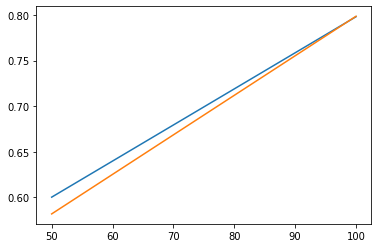

In [ ]:
iter = 4
epochs = 100
avg = []
comb = []
iters = [50, 100]

for spars in iters:
    # load the models
    classification_models = [tf.keras.models.load_model("/content/drive/MyDrive/FederatedLearning/heterogeneity"+str(int(0.4*100))+"/classification"+str(spars)+"/cluster"+
                                                            str(cluster.number)+"_"+str(spars)+"sparse_iter"+
                                                            str(iter)+".h5") for cluster in clusters]

    # produce the cluster outputs
    softmax_train_outputs = []
    softmax_validation_outputs = []
    for cluster_model in classification_models:
        softmax_train_outputs.append(cluster_model.predict(server_images_train))
        softmax_validation_outputs.append(cluster_model.predict(server_images_validation))
    softmax_clusters_train = []
    softmax_clusters_validation = []
    for i in range(375):
        temp = np.zeros((4, 10))
        for j in range(4):
            temp[j] = softmax_train_outputs[j][i]
        softmax_clusters_train.append(temp)
    softmax_clusters_train = np.asarray(softmax_clusters_train)
    for i in range(125):
        temp = np.zeros((4, 10))
        for j in range(4):
            temp[j] = softmax_validation_outputs[j][i]
        softmax_clusters_validation.append(temp)
    softmax_clusters_validation = np.asarray(softmax_clusters_validation)

    combiner = only_outputs()
    #history = combiner.fit([softmax_clusters_train, server_images_train], server_labels_train, epochs=epochs, verbose=0, validation_data=([softmax_clusters_validation, server_images_validation], server_labels_validation))
    history = combiner.fit(softmax_clusters_train, server_labels_train, epochs=epochs, verbose=0, validation_data=(softmax_clusters_validation, server_labels_validation))

    softmax_outputs = []
    for model in classification_models:
        softmax_outputs.append(model.predict(X_test))

    averaging = sum(softmax_outputs) 
    acc = 0
    for i in range(len(averaging)):
        if np.argmax(averaging[i]) == Y_test[i]:
            acc += 1
    print("Accuracy of the averaging: " + str(100*acc/len(averaging)) + "%")
    avg.append(acc/len(averaging))

    to_give = []
    for i in range(len(X_test)):
        temp = np.zeros((4, 10))
        for j in range(4):
            temp[j] = softmax_outputs[j][i]
        to_give.append(temp)
    to_give = np.asarray(to_give)

    #_, accuracy = custom_model.evaluate([to_give, X_test], to_categorical(Y_test, 10))
    _, accuracy = custom_model.evaluate(to_give, to_categorical(Y_test, 10))
    print("Accuracy of the combiner is " + str(accuracy*100) + "%\n")
    comb.append(accuracy)
plt.figure()
plt.plot(iters, avg)
plt.plot(iters, comb)

# Test 8-th June: MNIST

In [ ]:
X_train, Y_train, X_test, Y_test = load_preprocessed_mnist()

classification_path = "/content/drive/MyDrive/Colab Notebooks/classification_models_mnist/het" + str(int(bias_factor*100)) + "_class_perc" + str(classification_percentage) + "/cluster" 
estimation_path = "/content/drive/MyDrive/Colab Notebooks/estimation_models_mnist_autoencoder/het" + str(int(bias_factor*100)) + "_est_perc" + str(estimation_percentage) + "/cluster" 

average_performances = []
estimated_marginals_performances = []

for _ in range(2, iterations-1):

    classification_models = [tf.keras.models.load_model(classification_path + str(cluster.number) + "_iter" + str(_) + ".h5") for cluster in clusters]
    estimation_models = [tf.keras.models.load_model(estimation_path+ str(cluster.number) + "_iter" + str(_) + ".h5") for cluster in clusters]

    # the order is not important when perform the avg
    softmax_outputs = []
    for model in classification_models:
        softmax_outputs.append(model.predict(X_test))

    averaging = sum(softmax_outputs) 
    acc = 0
    for i in range(len(averaging)):
        if np.argmax(averaging[i]) == np.argmax(Y_test[i]):
            acc += 1
    print("Accuracy of the averaging: " + str(100*acc/len(averaging)) + "%")
    average_performances.append(acc/len(averaging))

    bce = tf.keras.losses.BinaryCrossentropy()
    reconstructions = []
    for model in estimation_models:
        reconstructions.append(model.predict(X_test.reshape((len(X_test), 28, 28))))

    # simple multiplication
    returned_losses = []
    for j in range(len(estimation_models)):
        model_specific_losses = []
        for i in range(len(reconstructions[j])):
            model_specific_losses.append(bce(reconstructions[j][i], X_test[i]).numpy())
        returned_losses.append(model_specific_losses)
    
    # compute the softmax weights
    for i in range(len(X_test)):
        array = [returned_losses[est_mod_ind][i] for est_mod_ind in range(len(estimation_models))]
        array = softmax(array)
        for ind in range(len(estimation_models)):
            returned_losses[ind][i] = array[ind]
    '''
    for img in range(len(X_test)):
        attempt = []
        for cluster in range(len(clusters)):
            attempt.append(returned_losses[cluster][img])
        attempt = attempt-np.average(attempt)
        attempt = attempt/np.sqrt(np.sum([el**2 for el in attempt]))
        for cluster in range(len(clusters)):
            returned_losses[cluster][img] = attempt[cluster]
    '''

    #cheating = [[0,0,0,0,0,0,1,0,0,0], [0,0,0,1,0,0,0,0,0,0], [0,0,0,0,0,0,0,1,0,0], [0,0,0,0,1,0,0,0,0,0], [0,0,0,0,0,0,1,0,0,0]]
    weighted = []
    for j in range(len(clusters)):
        for i in range(len(X_test)):
            softmax_outputs[j][i] = softmax_outputs[j][i]*returned_losses[j][i]
            ''' for cheating
            if np.argmax(Y_test[i]) in [3, 4, 6, 7]:
                softmax_outputs[j][i] *= cheating[j][np.argmax(Y_test[i])]
            ''' 

    weighted_averaging = sum(softmax_outputs) 
    acc = 0
    for i in range(len(weighted_averaging)):
        if np.argmax(weighted_averaging[i]) == np.argmax(Y_test[i]):
            acc += 1
    print("Accuracy of the weighted averaging: " + str(100*acc/len(weighted_averaging)) + "%\n")
    estimated_marginals_performances.append(acc/len(weighted_averaging))

plt.plot(range(iterations-1), average_performances)
plt.plot(range(iterations-1), estimated_marginals_performances)

Accuracy of the averaging: 48.97%
Accuracy of the weighted averaging: 48.02%

Accuracy of the averaging: 55.91%


# July 2021: weights/features aggregation

In [ ]:
# try to make a weighted average of the cnn weights, according to the estimation error

classification_path = "/content/drive/MyDrive/Colab Notebooks/classification_models_mnist/het" + str(int(bias_factor*100)) + "_class_perc" + str(classification_percentage) + "/cluster" 
estimation_path = "/content/drive/MyDrive/Colab Notebooks/estimation_models_mnist_autoencoder/het" + str(int(bias_factor*100)) + "_est_perc" + str(estimation_percentage) + "/cluster" 

local_list, softmax_avg_list, weight_avg_list, estim_marg_list = [], [], [], []
range_of_test = range(iterations-2, iterations-1)
for _ in range_of_test:
    print("\n### Iteration " + str(_) + " ###")

    classification_models = [tf.keras.models.load_model(classification_path + str(cluster.number) + "_iter" + str(_) + ".h5") for cluster in clusters]
    estimation_models = [tf.keras.models.load_model(estimation_path+ str(cluster.number) + "_iter" + str(_) + ".h5") for cluster in clusters]

    # averaging of the model weights
    new_weights = classification_models[0].weights
    for layer in range(len(new_weights)):
        new_weights[layer] = sum([(1/len(classification_models))*model.weights[layer] for model in classification_models])

    avg_clust_local, avg_clust_softmax_avg, avg_clust_weight_avg, avg_clust_est_marg = 0, 0, 0, 0

    for cluster in clusters:
        print("\nCluster number " + str(cluster.number))
        # load cluster local test set
        cluster_x_test = cluster.test_data['images']
        cluster_y_test = cluster.test_data['labels']

        # compute the performance of the local model
        tmp_avg_clust_local = classification_models[cluster.number].evaluate(cluster_x_test, cluster_y_test, verbose=0)[1]*100
        print("Acc of the local model: " + str(tmp_avg_clust_local))
        avg_clust_local += tmp_avg_clust_local/len(clusters)

        # compute the average of each softmax output and then display the performance on the local dataset
        softmax_outputs = []
        for model in classification_models:
            softmax_outputs.append(model.predict(cluster_x_test))
        averaging = sum(softmax_outputs) 
        acc = 0
        for i in range(len(averaging)):
            if np.argmax(averaging[i]) == np.argmax(cluster_y_test[i]):
                acc += 1
        tmp_avg_clust_softmax_avg = 100*acc/len(averaging)
        print("Acc of the softmax averaging: " + str(tmp_avg_clust_softmax_avg))
        avg_clust_softmax_avg += tmp_avg_clust_softmax_avg/len(clusters)

        # weighted average of softmax outputs using binary crossentropy ######################################################################
        bce = tf.keras.losses.BinaryCrossentropy()
        reconstructions = []
        for model in estimation_models:
            reconstructions.append(model.predict(cluster_x_test.reshape((len(cluster_x_test), 28, 28))))

        # simple multiplication
        returned_losses = []
        for j in range(len(estimation_models)):
            model_specific_losses = []
            for i in range(len(reconstructions[j])):
                model_specific_losses.append(bce(reconstructions[j][i], cluster_x_test[i]).numpy())
            returned_losses.append(model_specific_losses)
        
        # compute the softmax weights
        # try without
        #for i in range(len(cluster_x_test)):
           # array = [returned_losses[est_mod_ind][i] for est_mod_ind in range(len(estimation_models))]
           # array = softmax(array)
           # for ind in range(len(estimation_models)):
           #     returned_losses[ind][i] = array[ind]

        weighted = []
        for j in range(len(clusters)):
            for i in range(len(cluster_x_test)):
                softmax_outputs[j][i] = softmax_outputs[j][i]*returned_losses[j][i]

        weighted_averaging = sum(softmax_outputs) 
        acc = 0
        for i in range(len(weighted_averaging)):
            if np.argmax(weighted_averaging[i]) == np.argmax(cluster_y_test[i]):
                acc += 1

        tmp_avg_clust_est_marg = 100*acc/len(weighted_averaging)
        avg_clust_est_marg += tmp_avg_clust_est_marg/len(clusters)
        print("ACC of the estimated marginals weighted avg: " + str(tmp_avg_clust_est_marg))

        #######################################################################################################################################

        # create the model with the avg weights
        average_weight_model = classification_models[0]
        average_weight_model.set_weights(new_weights)
        tmp_avg_clust_weight_avg = average_weight_model.evaluate(cluster_x_test, cluster_y_test, verbose=0)[1]*100
        print("Acc of the average-weights model: " + str(tmp_avg_clust_weight_avg))
        avg_clust_weight_avg += tmp_avg_clust_weight_avg/len(clusters)

    local_list.append(avg_clust_local)
    softmax_avg_list.append(avg_clust_softmax_avg)
    weight_avg_list.append(avg_clust_weight_avg)
    estim_marg_list.append(avg_clust_weight_avg)

plt.plot(range_of_test, local_list, label="localcc")
plt.plot(range_of_test, softmax_avg_list, label="softmax avg")
plt.plot(range_of_test, weight_avg_list, label="weights avg")
plt.plot(range_of_test, estim_marg_list, label="estimated marginals")
plt.legend(loc="upper left")
plt.xlabel("iteration")
plt.ylabel("avg accuracy on the local datasets")
plt.show()


### Iteration 5 ###

Cluster number 0
Acc of the local model: 73.7500011920929
Acc of the softmax averaging: 80.5
ACC of the estimated marginals weighted avg: 80.15
Acc of the average-weights model: 83.89999866485596

Cluster number 1
Acc of the local model: 66.35000109672546
Acc of the softmax averaging: 77.1
ACC of the estimated marginals weighted avg: 77.2
Acc of the average-weights model: 78.75000238418579

Cluster number 2
Acc of the local model: 73.90000224113464
Acc of the softmax averaging: 79.55
ACC of the estimated marginals weighted avg: 78.45
Acc of the average-weights model: 79.6500027179718

Cluster number 3
Acc of the local model: 69.9999988079071
Acc of the softmax averaging: 78.7


KeyboardInterrupt: ignored

In [ ]:
# NOTE THAT TO OBTAIN THIS PLOT I HAVE USED THE 25% OF THE LOCAL DATA INSTEAD OF THE TOTAL AMOUNT! LOOK AT THE TRAINING METHOD: 